<a href="https://colab.research.google.com/github/danb-neo4j/patient_journey_chatGPT/blob/main/patientJourney_tabularEDA_chatGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Patient Journey Demo: Tabular Exploratory Data Analysis with ChatGPT
## Notebook Overview
This notebook is an adaptation of my prior [Patient Journey Tabular EDA notebook](https://github.com/danb-neo4j/patient_journey/blob/main/patientJourney_tabularEDA.ipynb). The full patient journey analysis is available [in this Github repo](https://github.com/danb-neo4j/patient_journey).

In this revised notebook we will demonstrate how to incorporate OpenAI's [ChatGPT API](https://openai.com/blog/introducing-chatgpt-and-whisper-apis) into performing exploratory data analysis (EDA) aimed at using tabular data in a Neo4j database. EDA is a critical step for analyzing data and designing a strong-performing graph data model. Incorporating ChatGPT can help with that process, especially by identifying analytic steps that might otherwise be overlooked.

## Data
The tabular data we are using is [Synthea Synthetic Patient Data](https://synthea.mitre.org/) and contains approximately 5,000 patients. The full data set is available in [this Google drive share](https://drive.google.com/drive/folders/1OqoYdHdW5e0eeeS6Idj3BTtLeDjEgIOz?usp=sharing). A smaller Synthea data set is published to the [Github repo](https://github.com/PacktPublishing/Cypher-Querying) associated with the book [Graph Data Processing with Cypher](https://www.packtpub.com/product/graph-data-processing-with-cypher/9781804611074).

The full Synthea data contains multiple CSVs, but with this notebook and subsequent demo we will focus on the following:
* Patients
* Encounters
* Procedures
* Medications (Drugs)


*Last Updated: 10 May 2023*

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette("colorblind")
sns.set(rc={'figure.figsize':(12,7)})

import os
import configparser
from IPython.display import Image
from datetime import datetime, date

## Mount Google Drive

In [2]:
from google.colab import drive 
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# change working directory 
os.chdir('drive/MyDrive/Colab Notebooks/gds_demos/patient_journey/')
DATA_DIRECTORY = 'data/'

# Data Directories

In [4]:
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/gds_demos/patient_journey'

# OpenAI ChatGPT

## Install or Import OpenAI Library

In [5]:
# import or install openai
try: 
    import openai
    print('Successfully imported openai')
except ModuleNotFoundError:
    !pip install openai
    import openai 
    print('installed and imported GraphDataScience')

Successfully imported openai


## Set API Key
To use ChatGPT you will need to sign up with an account and obtain an API key. 

In [6]:
# assign openai api key
api_key_path = 'openAI/openAI_API.txt'
OPENAI_API_KEY = open(api_key_path, 'r').read().strip('\n')
openai.api_key = OPENAI_API_KEY


## Set Model and Test Connection

In [18]:
# # get list  of models 
# openAI_models = !curl https://api.openai.com/v1/models \-H "Authorization: Bearer $OPENAI_API_KEY"
# openAI_models

In [7]:
# set openai model 
model = 'gpt-3.5-turbo'

In [8]:
# test api connection
prompt='What is the circumference of the planet Mars?'
messages = [{'role':'user', 'content': prompt}]

response = openai.ChatCompletion.create(model=model, messages=messages, temperature=0)

In [9]:
response.choices[0].message['content']

'The circumference of Mars is approximately 21,344 kilometers (13,265 miles).'

## Helper Function to Capture Message History

In [10]:
# set starter message history object
message_history = []

In [11]:
def submit_query_and_append(prompt=prompt, message_history=message_history):
    """Submit a query to the openai chatbot and append the response to the message history"""
    # append the prompt to the message history
    message_history.append({'role':'user', 'content': prompt})

    # submit query to openai chatbot
    response = openai.ChatCompletion.create(model=model, messages=message_history, temperature=0)

    # append the response to the message history 
    response_text = response.choices[0].message['content']
    message_history.append({'role':'assistant', 'content': response_text})

    return message_history, response_text

# Patient Data
Since this is a patient journey analysis, we will start by exploring the patient data. 

## Import Data

In [35]:
# read-in patient data 
patient_df = pd.read_csv(DATA_DIRECTORY + 'patients.csv')
patient_df.shape

(5885, 27)

In [36]:
patient_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5885 entries, 0 to 5884
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   5885 non-null   object 
 1   BIRTHDATE            5885 non-null   object 
 2   DEATHDATE            885 non-null    object 
 3   SSN                  5885 non-null   object 
 4   DRIVERS              4937 non-null   object 
 5   PASSPORT             4641 non-null   object 
 6   PREFIX               4792 non-null   object 
 7   FIRST                5885 non-null   object 
 8   LAST                 5885 non-null   object 
 9   SUFFIX               76 non-null     object 
 10  MAIDEN               1572 non-null   object 
 11  MARITAL              4066 non-null   object 
 12  RACE                 5885 non-null   object 
 13  ETHNICITY            5885 non-null   object 
 14  GENDER               5885 non-null   object 
 15  BIRTHPLACE           5885 non-null   o

## Format Date Columns

In [41]:
# format birthdate to datetime 
patient_df['BIRTHDATE'] = pd.to_datetime(patient_df['BIRTHDATE']).dt.date
patient_df['DEATHDATE'] = pd.to_datetime(patient_df['DEATHDATE']).dt.date

In [38]:
# view first two rows
patient_df.head(2)

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,MAIDEN,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,ADDRESS,CITY,STATE,COUNTY,FIPS,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,INCOME
0,75bef938-819a-ce94-8dc9-17dc50077a86,1991-11-22,NaN,999-68-3502,S99951806,X84544248X,Mrs.,Joi660,Barrows492,NaN,Schinner682,M,white,nonhispanic,F,Methuen Massachusetts US,811 Little Orchard Suite 57,Fall River,Massachusetts,Bristol County,25005.0,2720,41.724408,-71.203884,36108.19,219006.29,144427
1,faf277d8-c5c7-406c-f139-9143c35ff4e8,1987-09-28,NaN,999-51-6719,S99958687,X29099987X,Mr.,Billy698,McLaughlin530,NaN,NaN,M,white,nonhispanic,M,Boston Massachusetts US,871 Klein Stravenue Suite 70,North Lakeville,Massachusetts,Plymouth County,NaN,0,41.869110,-70.904529,6685.55,68732.89,10147


## Ask OpenAI for General Patient EDA Guidance
While standard tabular EDA steps are well known, it is never a good idea to ask for advice even as a checklist to make sure you aren't missing something. However, we will start by asking which features we should potentially focus on given our goal of ingesting the data into Neo4j and using it for a patient journey analysis. 

In [39]:
# create a detailed prompt that includes context about the data 
prompt = f"""I have a dataframe of patient data that contains {patient_df.shape[0]} rows and the following columns\n {patient_df.dtypes}. 
             \n The first five rows of my data are as follows: \n {patient_df.head(5)} \n
             I cannot explore or use all of the data, so which five to seven patient_df features, excluding 'Id', 'First', and 'Last', are likely  most important 
             if my goal is ingesting them into Neo4j, along with other related data, to perform a patient journey analysis?"""

# clear out the message history
message_history = []

# submit the prompt and update the message history 
message_history, response_text = submit_query_and_append(prompt, message_history)

In [40]:
print(response_text) 

Based on the goal of performing a patient journey analysis, the most important features to ingest into Neo4j would likely be:

1. BIRTHDATE - to track age and potential age-related health issues
2. DEATHDATE - to track mortality and end of patient journey
3. MARITAL - to track potential family support and caregiver involvement
4. RACE - to track potential health disparities and cultural factors
5. GENDER - to track potential gender-related health issues and differences
6. ADDRESS - to track potential environmental and social determinants of health
7. HEALTHCARE_EXPENSES - to track healthcare utilization and potential financial barriers to care.


The suggested features aren't bad, but I am not sure they are what I would want to use for my analysis. That said, it doesn't hurt to get a separate opinion.

## Feature Engineering

## Create AGE and DECEASED Features
Before analyzing the data further, I want to create two new features:
* DECEASED, which is a boolean to identify if a patient has a DEATHDATE
* AGE, which is calculated as 1 May 2023 minus the BIRTHDATE for living patients or as the DEATHDATE minus the BIRTHDATE for deceased patients.

To do this, I will ask ChatGPT to provide code for assistance.


In [46]:
# create a detailed prompt that includes context about the data 
prompt = f"""I want you to act as a data scientist and help me write Python code. I have a pandas dataframe called patient_df that contains patient
             BIRTHDATE and DEATHDATE features, both of which are pandas dates. The DEATHDATE is null if a patient is not deceased.
             I want to create a boolean feature named DECEASED that is True if the patient has a non-null DEATHDATE. Then I want to creat
             an AGE feature that calculates the patient's age either from May 1, 2023 if they are not deceased or from the DEATHDATE
             if they are deceased. Please provide Python code for how I can do this."""

# clear out the message history
message_history = []

# submit the prompt and update the message history 
message_history, response_text = submit_query_and_append(prompt, message_history)

In [47]:
print(response_text)

Here is the Python code to create the DECEASED and AGE features in the patient_df dataframe:

```
import pandas as pd
import numpy as np

# create sample patient_df dataframe
patient_df = pd.DataFrame({
    'BIRTHDATE': ['1990-01-01', '1985-05-10', '1970-12-25', '1950-03-15'],
    'DEATHDATE': [np.nan, '2020-06-01', np.nan, '2010-01-01']
})

# create DECEASED feature
patient_df['DECEASED'] = ~patient_df['DEATHDATE'].isnull()

# create AGE feature
today = pd.Timestamp('2023-05-01')
patient_df['AGE'] = np.where(patient_df['DECEASED'], 
                             (pd.to_datetime(patient_df['DEATHDATE']) - pd.to_datetime(patient_df['BIRTHDATE'])).dt.days / 365.25, 
                             (today - pd.to_datetime(patient_df['BIRTHDATE'])).dt.days / 365.25)

print(patient_df)
```

Output:
```
    BIRTHDATE   DEATHDATE  DECEASED        AGE
0  1990-01-01         NaN     False  33.326693
1  1985-05-10  2020-06-01      True  35.032787
2  1970-12-25         NaN     False  52.375342
3  1950

In [45]:
# create DECEASED feature
patient_df['DECEASED'] = ~patient_df['DEATHDATE'].isnull()

In [50]:
# create an age feature
may_1_2023 = pd.Timestamp('2023-05-01')

patient_df['AGE'] = np.where(patient_df['DECEASED'], 
                            (pd.to_datetime(patient_df['DEATHDATE']) - pd.to_datetime(patient_df['BIRTHDATE'])).dt.days / 365.25,
                            (may_1_2023 - pd.to_datetime(patient_df['BIRTHDATE'])).dt.days / 365.25)


In [52]:
patient_df['AGE'] = patient_df['AGE'].astype(int)

In [53]:
patient_df.head()

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,MAIDEN,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,ADDRESS,CITY,STATE,COUNTY,FIPS,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,INCOME,DECEASED,AGE
0,75bef938-819a-ce94-8dc9-17dc50077a86,1991-11-22,NaT,999-68-3502,S99951806,X84544248X,Mrs.,Joi660,Barrows492,NaN,Schinner682,M,white,nonhispanic,F,Methuen Massachusetts US,811 Little Orchard Suite 57,Fall River,Massachusetts,Bristol County,25005.0,2720,41.724408,-71.203884,36108.19,219006.29,144427,False,31
1,faf277d8-c5c7-406c-f139-9143c35ff4e8,1987-09-28,NaT,999-51-6719,S99958687,X29099987X,Mr.,Billy698,McLaughlin530,NaN,NaN,M,white,nonhispanic,M,Boston Massachusetts US,871 Klein Stravenue Suite 70,North Lakeville,Massachusetts,Plymouth County,NaN,0,41.869110,-70.904529,6685.55,68732.89,10147,False,35
2,4f01341c-4946-31cd-9f2e-7844867f1606,1979-07-30,NaT,999-82-1028,S99967942,X56759551X,Mr.,Dominic463,Ward668,NaN,NaN,M,white,nonhispanic,M,Agawam Massachusetts US,209 Cassin Brook Apt 47,Tyngsborough,Massachusetts,Middlesex County,NaN,0,42.639541,-71.417188,37041.63,6793.20,109151,False,43
3,63cd703f-3077-613f-adf0-85fc32f3ae2a,1971-01-22,NaT,999-72-1131,S99976682,X71554510X,Mr.,Ethan766,Nolan344,NaN,NaN,M,white,nonhispanic,M,New Bedford Massachusetts US,231 Champlin Mill,Westfield,Massachusetts,Hampden County,25013.0,1086,42.106060,-72.722163,16736.57,216336.28,78360,False,52
4,61b942b2-8324-0208-7e2f-5309af2be4f4,1968-04-06,NaT,999-12-8574,S99954876,X22547263X,Mr.,Arron144,Bashirian201,NaN,NaN,D,asian,nonhispanic,M,Easthampton Massachusetts US,422 Russel Branch Suite 52,Boston,Massachusetts,Suffolk County,25025.0,2210,42.385920,-71.056706,57242.58,195281.25,416323,False,55


## Create Limited Patient DataFrame
We are only going to analyze and use a small portion of the patient_df data, so to simplify the analysis will copy those features into a new dataframe. 

In [59]:
# create patient EDA dataframe
patient_eda_cols = ['Id', 'FIRST', 'LAST', 'SSN', 'BIRTHDATE', 'DEATHDATE', 'DECEASED', 'AGE', 'GENDER', 'RACE', 'INCOME', 'HEALTHCARE_EXPENSES', 'ZIP']
patient_df_eda = patient_df[patient_eda_cols].copy()
patient_df_eda.shape 

(5885, 13)

## Ask ChatGPT for Specific Patient EDA Guidance and Examples

In [55]:
prompt = f"""I want you to continue acting as an experienced data scientist. I new patient dataframe
             called patient_df_eda that contains the following features:\n {patient_df_eda.columns}. \n
             The first five rows of this data are as follows: \n {patient_df.head(5)} \n
             What hat steps should I take to perform exploratory data analysis on this dataframe?
             Provide python examples using pandas for statistical analysis and seaborn for visualization.
             The data is already in a pandas dataframe."""

message_history, response_text = submit_query_and_append(prompt, message_history)

In [56]:
print(response_text)

To perform exploratory data analysis on the patient_df_eda dataframe, we can follow these steps:

1. Check the data types of each feature using the dtypes attribute.
2. Check for missing values using the isnull() method and visualize them using seaborn's heatmap.
3. Check for outliers and distribution of numerical features using pandas' describe() method and seaborn's distplot and boxplot.
4. Check for correlations between numerical features using seaborn's heatmap and pairplot.
5. Check for distribution of categorical features using pandas' value_counts() method and seaborn's countplot.

Here is the Python code to perform these steps:

```
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load patient_df_eda dataframe
patient_df_eda = pd.read_csv('patient_df_eda.csv')

# check data types
print(patient_df_eda.dtypes)

# check missing values
sns.heatmap(patient_df_eda.isnull(), cmap='viridis')
plt.show()

# check numerical features
print(patient_df_eda.describ

## General Patient EDA

In [60]:
patient_df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5885 entries, 0 to 5884
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   5885 non-null   object 
 1   FIRST                5885 non-null   object 
 2   LAST                 5885 non-null   object 
 3   SSN                  5885 non-null   object 
 4   BIRTHDATE            5885 non-null   object 
 5   DEATHDATE            885 non-null    object 
 6   DECEASED             5885 non-null   bool   
 7   AGE                  5885 non-null   int64  
 8   GENDER               5885 non-null   object 
 9   RACE                 5885 non-null   object 
 10  INCOME               5885 non-null   int64  
 11  HEALTHCARE_EXPENSES  5885 non-null   float64
 12  ZIP                  5885 non-null   int64  
dtypes: bool(1), float64(1), int64(3), object(8)
memory usage: 557.6+ KB


In [58]:
patient_df_eda.head()

,Id,FIRST,LAST,SSN,BIRTHDATE,DEATHDATE,AGE,GENDER,RACE,INCOME,HEALTHCARE_EXPENSES,ZIP
0,75bef938-819a-ce94-8dc9-17dc50077a86,Joi660,Barrows492,999-68-3502,1991-11-22,NaT,31,F,white,144427,36108.19,2720
1,faf277d8-c5c7-406c-f139-9143c35ff4e8,Billy698,McLaughlin530,999-51-6719,1987-09-28,NaT,35,M,white,10147,6685.55,0
2,4f01341c-4946-31cd-9f2e-7844867f1606,Dominic463,Ward668,999-82-1028,1979-07-30,NaT,43,M,white,109151,37041.63,0
3,63cd703f-3077-613f-adf0-85fc32f3ae2a,Ethan766,Nolan344,999-72-1131,1971-01-22,NaT,52,M,white,78360,16736.57,1086
4,61b942b2-8324-0208-7e2f-5309af2be4f4,Arron144,Bashirian201,999-12-8574,1968-04-06,NaT,55,M,asian,416323,57242.58,2210


In [ ]:
# check for missing values
patient_df_eda.isna().sum()

Id                        0
FIRST                     0
LAST                      0
SSN                       0
BIRTHDATE                 0
DEATHDATE              5000
AGE                       0
GENDER                    0
RACE                      0
ETHNICITY                 0
INCOME                    0
HEALTHCARE_EXPENSES       0
ZIP                       0
dtype: int64

In [ ]:
# check for duplicates 
print('count of duplicates in the data', patient_df.duplicated().sum())

count of duplicates in the data 0


## Fix ZIP Feature
The ZIP feature is an integer, which is removing the leading zeros. We will ask ChatGPT for help changing this to a string and padding zeros from the left.

In [62]:
prompt = f"""I want you to continue acting as an experienced data scientist. I have a pandas
             dataframe called patient_df_eda which has an 'int64' feature called ZIP. 
             This feature contains United States zip codes. Provide me with code to convert
             this feature to a string and pad it with zeros to the left so each code contains a 
             total of five characters."""

message_history, response_text = submit_query_and_append(prompt, message_history)

In [63]:
print(response_text)

Sure, here's the Python code to convert the ZIP feature to a string and pad it with zeros to the left:

```
# convert ZIP feature to string
patient_df_eda['ZIP'] = patient_df_eda['ZIP'].astype(str)

# pad ZIP feature with zeros to the left
patient_df_eda['ZIP'] = patient_df_eda['ZIP'].str.pad(width=5, side='left', fillchar='0')

print(patient_df_eda['ZIP'])
```

Explanation:
- We first convert the ZIP feature to a string using the astype() method.
- We then use the str.pad() method to pad the ZIP feature with zeros to the left. The width parameter specifies the total width of the resulting string, the side parameter specifies which side to pad (in this case, 'left'), and the fillchar parameter specifies the character to use for padding (in this case, '0').
- We print the resulting ZIP feature to verify that it has been converted to a string and padded with zeros to the left.


In [64]:
# convert ZIP feature to string
patient_df_eda['ZIP'] = patient_df_eda['ZIP'].astype(str)

# pad ZIP feature with zeros to the left
patient_df_eda['ZIP'] = patient_df_eda['ZIP'].str.pad(width=5, side='left', fillchar='0')

In [65]:
patient_df_eda.head()

,Id,FIRST,LAST,SSN,BIRTHDATE,DEATHDATE,DECEASED,AGE,GENDER,RACE,INCOME,HEALTHCARE_EXPENSES,ZIP
0,75bef938-819a-ce94-8dc9-17dc50077a86,Joi660,Barrows492,999-68-3502,1991-11-22,NaT,False,31,F,white,144427,36108.19,02720
1,faf277d8-c5c7-406c-f139-9143c35ff4e8,Billy698,McLaughlin530,999-51-6719,1987-09-28,NaT,False,35,M,white,10147,6685.55,00000
2,4f01341c-4946-31cd-9f2e-7844867f1606,Dominic463,Ward668,999-82-1028,1979-07-30,NaT,False,43,M,white,109151,37041.63,00000
3,63cd703f-3077-613f-adf0-85fc32f3ae2a,Ethan766,Nolan344,999-72-1131,1971-01-22,NaT,False,52,M,white,78360,16736.57,01086
4,61b942b2-8324-0208-7e2f-5309af2be4f4,Arron144,Bashirian201,999-12-8574,1968-04-06,NaT,False,55,M,asian,416323,57242.58,02210


## Patient Numeric Features

### Statistical Distributions

In [66]:
# statistical distributions of numeric features
patient_df_eda.describe(percentiles=[0, 0.25, 0.5,0.75, 0.9, 0.95, 0.99]).round(0)

,AGE,INCOME,HEALTHCARE_EXPENSES
count,5885.0,5885.0,5885.0
mean,42.0,121165.0,136704.0
std,24.0,175711.0,326881.0
min,0.0,9.0,100.0
0%,0.0,9.0,100.0
25%,23.0,32353.0,18520.0
50%,43.0,69718.0,44011.0
75%,60.0,128589.0,77246.0
90%,73.0,194285.0,295967.0
95%,82.0,559674.0,832278.0


### Patient Age

In [71]:
# distribution of deceased patients
print('Percentage of patients who are deceased:')
patient_df_eda['DECEASED'].value_counts(normalize=True).round(2)

Percentage of patients who are deceased:


False    0.85
True     0.15
Name: DECEASED, dtype: float64

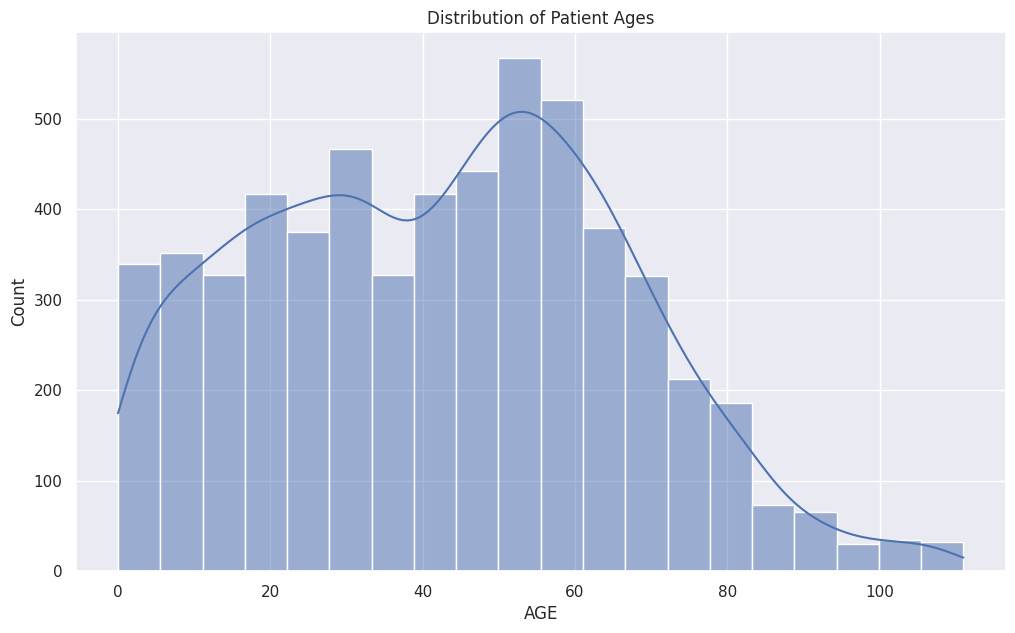

In [72]:
sns.histplot(patient_df_eda['AGE'], bins=20, kde=True)
plt.title('Distribution of Patient Ages')
plt.show()

#### Ask ChatGPT About Patient AGE Distribution

In [73]:
prompt = f"""
I want you to act as a data scientist and advise me about the distribution of a data feature. 
The distribution of patient ages in my data is: \n
{patient_df_eda['AGE'].describe(percentiles=[0, 0.25, 0.5,0.75, 0.9, 0.95, 0.99]).round(0)}\n
None of the patients are missing this feature.
Are there any considerations I should take when using this feature in my Neo4j graph for patient journey analysis?
"""
message_history, response_text = submit_query_and_append(prompt, message_history)
print(response_text)

Based on the distribution of patient ages you provided, it appears that the ages are relatively normally distributed with a mean of 42 and a standard deviation of 24. The minimum age is 0 and the maximum age is 111, which suggests that there may be some outliers in the data. 

When using this feature in your Neo4j graph for patient journey analysis, you should consider the following:

1. Outliers: As mentioned, there may be some outliers in the data. You should decide whether to include or exclude these outliers in your analysis, depending on the specific research question you are trying to answer.

2. Binning: You may want to consider binning the age feature into categories (e.g., 0-18, 19-35, 36-50, 51-65, 66-80, 81 and above) to simplify the analysis and make it easier to interpret.

3. Missing values: Although you mentioned that none of the patients are missing the age feature, it is always a good practice to check for missing values and handle them appropriately (e.g., impute miss

While ChatGPT provided good general advice, for now we probably won't act on the Age data beyond analyzing it alone and in relation to other features. Binning could be a useful option if we plan to train a machine learning model, but since that is not in the immediate future we won't do so now. 

### Patient Income and Healthcare Expenses 

### Ask ChatGPT for Guidance

In [75]:
message_history = []

In [76]:
prompt = f""" 
I want you to act as a data scientist and advise me about analyzing patient Income and Healthcare Expenses.
My data is already read-in to a pandas dataframe named patient_df_eda.
The distribution of patient income in my data is: 
\n{patient_df_eda['INCOME'].describe(percentiles=[0, 0.25, 0.5,0.75, 0.9, 0.95, 0.99]).round(0)}.\n 
The distribution of patient healthcare expenses in my data is: 
\n{patient_df_eda['HEALTHCARE_EXPENSES'].describe(percentiles=[0, 0.25, 0.5,0.75, 0.9, 0.95, 0.99]).round(0)}.\n 
What considerations should I take with this data before using it in my Neo4j graph for patient journey analysis?
What specific analysis should I perform? Provide python code using pandas and seaborn.
"""
message_history, response_text = submit_query_and_append(prompt, message_history)
print(response_text)


Before using this data in a Neo4j graph for patient journey analysis, it is important to consider the potential biases in the data. For example, the data may only represent a certain demographic or geographic area, and may not be representative of the entire population. Additionally, there may be missing data or outliers that need to be addressed before analysis.

To analyze the relationship between patient income and healthcare expenses, we can create a scatterplot using seaborn:

```
import seaborn as sns

sns.scatterplot(x='INCOME', y='HEALTHCARE_EXPENSES', data=patient_df_eda)
```

This will show us the overall trend between income and healthcare expenses. We can also use seaborn to create a regression plot to see the line of best fit:

```
sns.regplot(x='INCOME', y='HEALTHCARE_EXPENSES', data=patient_df_eda)
```

This will show us the relationship between income and healthcare expenses more clearly.

We can also use pandas to calculate the correlation coefficient between income an

### Statistical Distributions

### Histogram of Patient Income

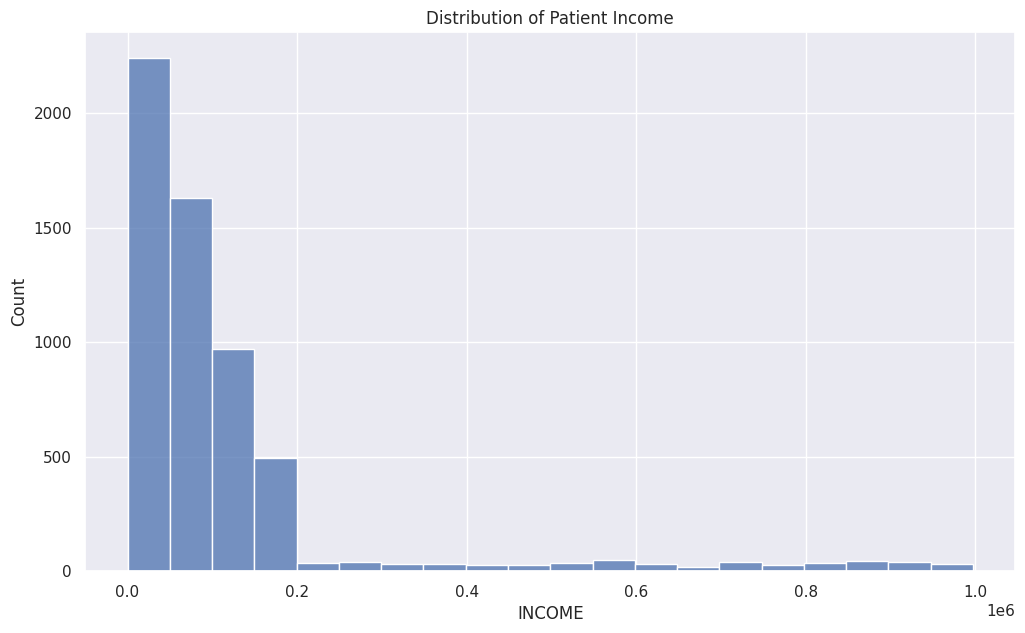

In [77]:
# plot distribution 
sns.histplot(data=patient_df, x='INCOME', bins=20)
plt.title('Distribution of Patient Income')
plt.show()

### HIstogram of Patient Healthcare Expenses

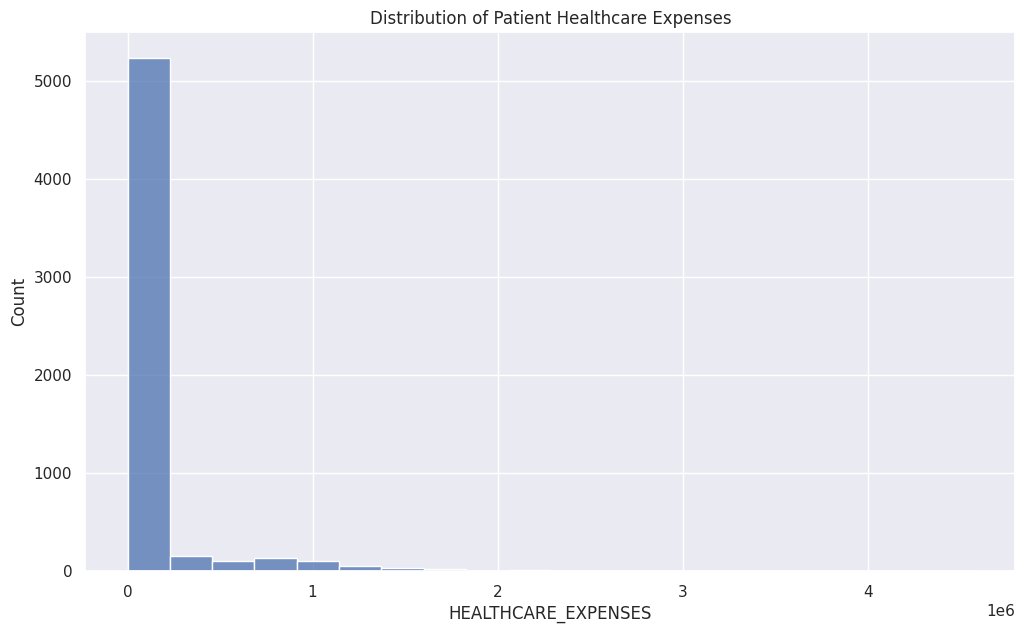

In [78]:
# plot distribution 
sns.histplot(data=patient_df, x='HEALTHCARE_EXPENSES', bins=20)
plt.title('Distribution of Patient Healthcare Expenses')
plt.show()

### Scatter Plot of Patient Income vs. Healthcare Expenses, by Gender

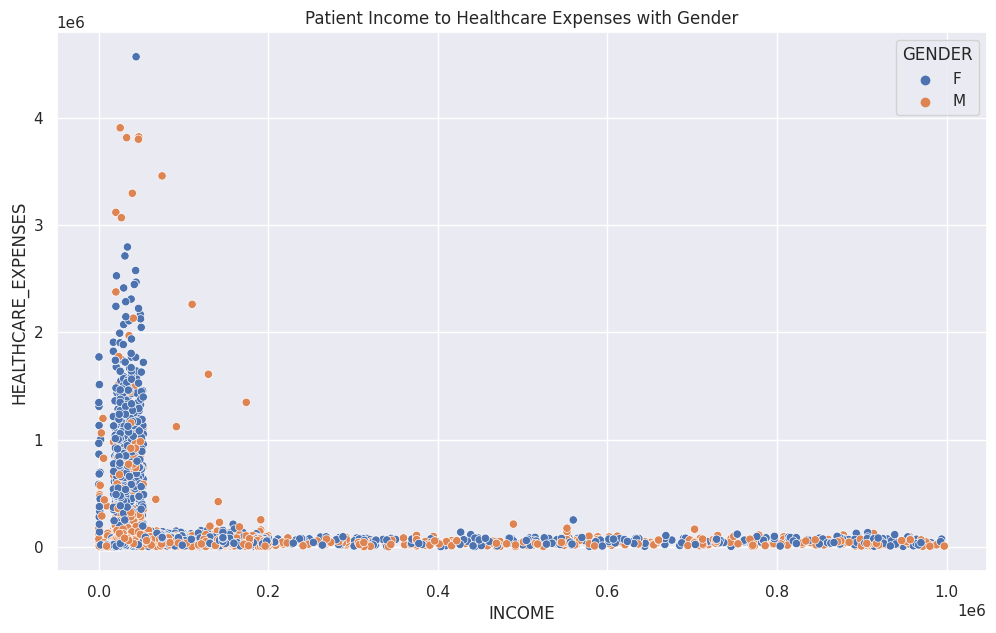

In [79]:
sns.scatterplot(data=patient_df, x='INCOME', y='HEALTHCARE_EXPENSES', hue='GENDER')
plt.title('Patient Income to Healthcare Expenses with Gender')
plt.show()

In [81]:
# calculate correlation 
patient_df_eda['INCOME'].corr(patient_df_eda['HEALTHCARE_EXPENSES'])

-0.13168019325940403

### Demographic Features

In [83]:
patient_df_eda.head(2)

,Id,FIRST,LAST,SSN,BIRTHDATE,DEATHDATE,DECEASED,AGE,GENDER,RACE,INCOME,HEALTHCARE_EXPENSES,ZIP
0,75bef938-819a-ce94-8dc9-17dc50077a86,Joi660,Barrows492,999-68-3502,1991-11-22,NaT,False,31,F,white,144427,36108.19,02720
1,faf277d8-c5c7-406c-f139-9143c35ff4e8,Billy698,McLaughlin530,999-51-6719,1987-09-28,NaT,False,35,M,white,10147,6685.55,00000


In [82]:
# # drop first 10 messages to avoid openai api limit
# message_history = message_history[10:]
print('not necessary')

not necessary


In [84]:
prompt = f""" 
I want you to act as a data scientist and advise me about analyzing patient demographics. 
My dataframe, called patient_df_eda, has the columns GENDER, RACE, and ZIP (which is a Unitd States Zip Code).
What considerations should I take with this data before using it in my Neo4j graph for patient journey analysis?
What specific analysis should I perform? Provide python code using pandas and seaborn.
"""
message_history, response_text = submit_query_and_append(prompt, message_history)
print(response_text)

Before using patient demographics data in a Neo4j graph for patient journey analysis, it is important to consider the potential biases in the data. For example, the data may only represent a certain demographic or geographic area, and may not be representative of the entire population. Additionally, there may be missing data or outliers that need to be addressed before analysis.

To analyze patient demographics, we can start by looking at the distribution of gender and race in the data using pandas:

```
import pandas as pd

gender_counts = patient_df_eda['GENDER'].value_counts()
race_counts = patient_df_eda['RACE'].value_counts()

print(gender_counts)
print(race_counts)
```

This will give us the count of each gender and race in the data. We can also use seaborn to create bar plots to visualize the distribution:

```
import seaborn as sns

sns.countplot(x='GENDER', data=patient_df_eda)
sns.countplot(x='RACE', data=patient_df_eda)
```

This will show us the distribution of gender and r

#### Patient Genders

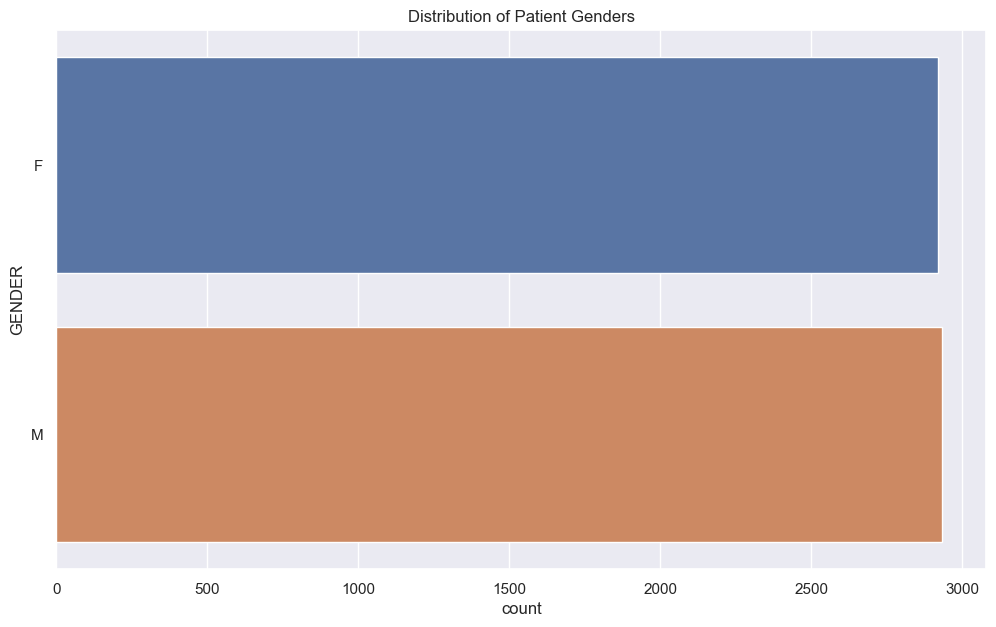

In [ ]:
sns.countplot(y='GENDER', data=patient_df_eda)
plt.title('Distribution of Patient Genders')
plt.show()

#### Patient Race and Ethnicity

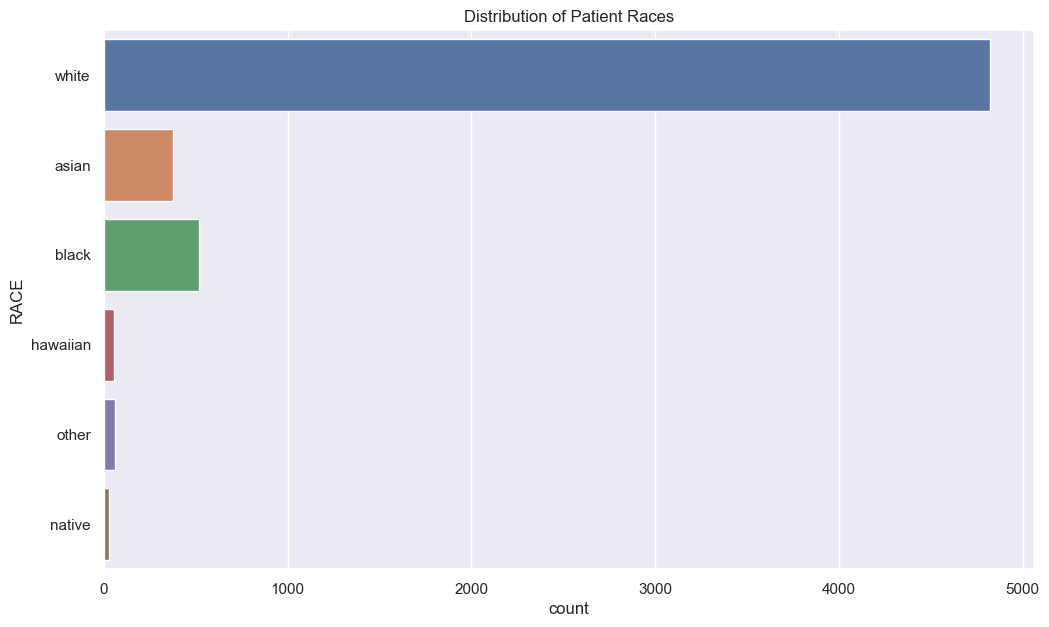

In [ ]:
sns.countplot(y='RACE', data=patient_df_eda)
plt.title('Distribution of Patient Races')
plt.show()

In [87]:
print('Mean Healthcare Expenses by Patient Gender and Race')
pd.pivot_table(patient_df_eda, values='HEALTHCARE_EXPENSES', index=['GENDER', 'RACE'], aggfunc='mean')

Mean Healthcare Expenses by Patient Gender and Race


HEALTHCARE_EXPENSES
GENDER RACE                         
F      asian           137576.291500
       black           197248.186642
       hawaiian         32087.580370
       native          237241.147857
       other           291742.563478
       white           191010.112816
M      asian           124101.044930
       black            52896.244344
       hawaiian         48634.285200
       native           38038.526667
       other            62797.533846
       white            86617.913710

#### Income and Expenses to Race

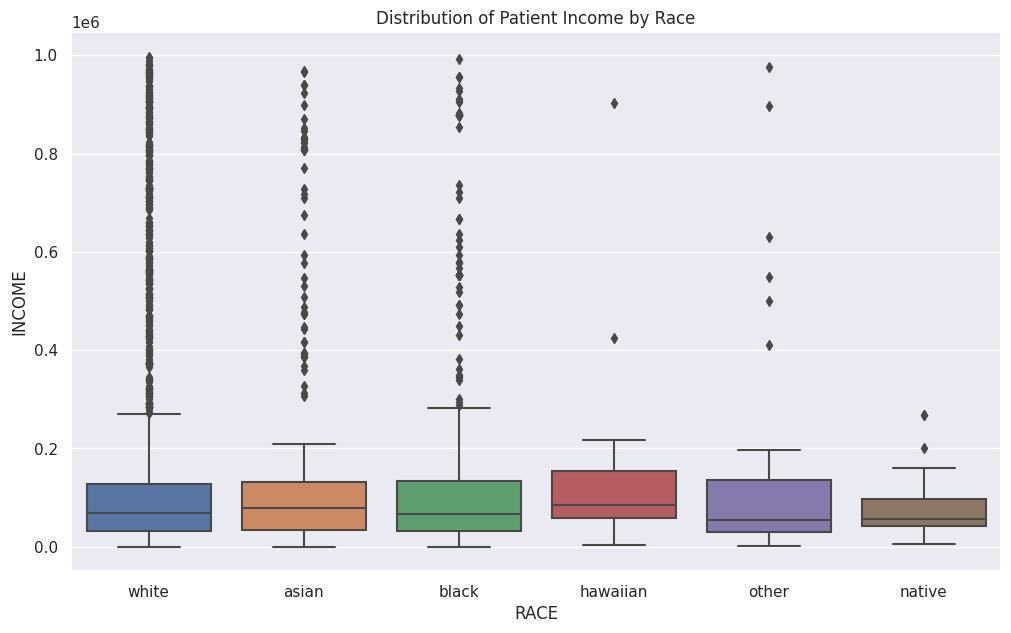

In [88]:
sns.boxplot(data=patient_df_eda, x='RACE', y='INCOME')
plt.title('Distribution of Patient Income by Race')
plt.show()

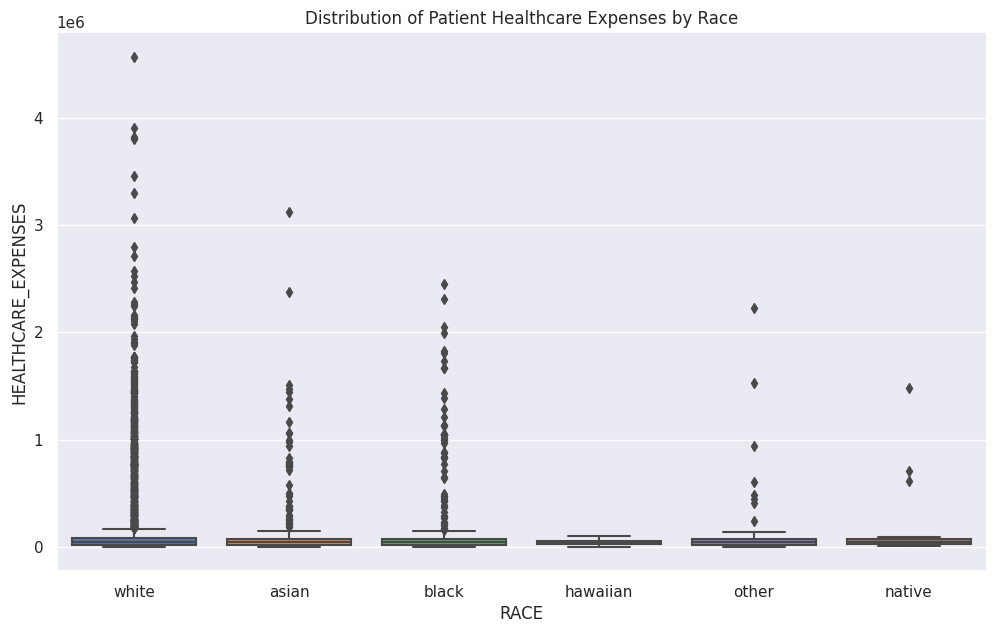

In [89]:
sns.boxplot(data=patient_df_eda, x='RACE', y='HEALTHCARE_EXPENSES')
plt.title('Distribution of Patient Healthcare Expenses by Race')
plt.show()

#### Zip Codes

In [90]:
patient_df_eda['ZIP'].nunique()

320

In [91]:
patient_df_eda['ZIP'].value_counts().head(10)

00000    1522
01940      70
02472      63
02155      59
01201      54
02148      52
02151      50
02351      48
01420      47
02360      47
Name: ZIP, dtype: int64

## Ask ChatGPT for Patient Graph Data Model
Here we will ask ChatGPT which features we should incorporate into our Neo4j data model. Although we are basing our model on the features included in [Graph Data Processing with Cypher](https://www.packtpub.com/product/graph-data-processing-with-cypher/9781804611074), we are focusing on a Patient Journey analysis leveraging the Graph Data Science library and therefore may want to adapt the nodes, relationships, and properties to better suit our usecase. 

In [ ]:
# drop first 10 messages to avoid openai api limit
message_history = message_history[10:]

In [94]:
prompt = f"""
I want you to act as an experienced graph data scientist and advise me about creating a Neo4j graph data model for a patient journey analysis. 
I have a pandas dataframe called patient_df_eda that contains the following features: \n {patient_df_eda.dtypes} \n
The first five rows of the data are:\n {patient_df_eda.head()} \n
I plan to ingest this data into Neo4j and use it, along with other data, for a patient journey analysis. 
I also plan to use centrality, community detection, node similarity, and embeddings algorithms from the Neo4j graph data science library. 
What features from the patients_df data frame should I include in my Neo4j graph data model as nodes and properites? 
And what relationships should I create between nodes? 
"""

message_history, response_text = submit_query_and_append(prompt, message_history)


In [98]:
print(response_text)

To create a Neo4j graph data model for patient journey analysis using the `patient_df_eda` dataframe, we need to identify the key entities and relationships in the data. Based on the information provided, some common entities and relationships that may be relevant for patient journey analysis include:

Entities:
- Patients: including properties such as patient ID, first name, last name, SSN, birthdate, deceased status, age, gender, race, income, and zip code
- Healthcare providers: including properties such as provider ID, name, specialty, and location
- Medical procedures: including properties such as procedure ID, name, and cost
- Medical conditions: including properties such as condition ID, name, and severity
- Healthcare facilities: including properties such as facility ID, name, location, and type

Relationships:
- Patient-provider: indicating which providers a patient has seen, and when
- Provider-procedure: indicating which procedures a provider has performed, and when
- Patien

## Save Updated Patient Data

In [ ]:
patient_df.to_csv(DATA_DIRECTORY + 'patients_updated.csv', index=None)

# Encounters Data

## Import and Pre-Format Data

In [100]:
encounters_df = pd.read_csv(DATA_DIRECTORY + 'encounters.csv')
encounters_df.shape

(497415, 15)

In [103]:
# convert start and stop to datetime objects
encounters_df['START'] = pd.to_datetime(encounters_df['START'])
encounters_df['STOP'] = pd.to_datetime(encounters_df['STOP'])

# convert code to an object
encounters_df['CODE'] = encounters_df['CODE'].astype('object')

## Ask OpenAI for EDA Guidance

In [104]:
prompt = f"""I have a dataframe of patient healthcare encounter (event) data that is already loaded into the pandas dataframe called encounters_df. 
             The dataframe contains {encounters_df.shape[0]} rows and the following features\n {encounters_df.dtypes}\n 
             I plan to ingest this parts of this data into Neo4j and use it along with patient, procedure, and medication data for a patient journey analysis. 
             I cannot use or analyze all of the encounter features, so which five to seven, excluding Id, would likely most important 
             to include in my Neo4j graph data model as nodes, properties, or relationships?
             """

# create a new message history variable for this section
message_history = []

message_history, response_text = submit_query_and_append(prompt, message_history)
print(response_text)

Based on the given information, the following five to seven encounter features could be important to include in the Neo4j graph data model:

1. START: This feature represents the start date and time of the healthcare encounter, which could be useful for analyzing the timing and duration of patient journeys.

2. STOP: This feature represents the end date and time of the healthcare encounter, which could be useful for analyzing the timing and duration of patient journeys.

3. PATIENT: This feature represents the unique identifier for the patient associated with the healthcare encounter, which could be useful for creating patient nodes and relationships in the graph data model.

4. PROVIDER: This feature represents the unique identifier for the healthcare provider associated with the healthcare encounter, which could be useful for creating provider nodes and relationships in the graph data model.

5. ENCOUNTERCLASS: This feature represents the type of healthcare encounter, such as inpatie

In [105]:
prompt = f"""
Continuing the conversation, I am most interested in the following features in my patient encounters dataframe encounters_df: START, ENCOUNTERCLASS, DESCRIPTION, CODE, TOTAL_CLAIM_COST.
What specific exploratory data analysis should I perform on the entire data set and these specific columns before ingesting it into Neo4j for a patient journey analysis?
Provide Python code examples using pandas and seaborn.
"""

message_history, response_text = submit_query_and_append(prompt, message_history)
print(response_text)

Before ingesting the data into Neo4j, it is important to perform exploratory data analysis (EDA) to gain insights into the data and identify any potential issues or anomalies. Here are some specific EDA tasks that can be performed on the entire dataset and the selected columns:

1. Check for missing values: It is important to check if any of the selected columns have missing values, as this can affect the analysis and modeling. 

```python
# Check for missing values in the selected columns
encounters_df[['START', 'ENCOUNTERCLASS', 'DESCRIPTION', 'CODE', 'TOTAL_CLAIM_COST']].isnull().sum()
```

2. Check data types: It is important to ensure that the data types of the selected columns are appropriate for the analysis and modeling. 

```python
# Check data types of the selected columns
encounters_df[['START', 'ENCOUNTERCLASS', 'DESCRIPTION', 'CODE', 'TOTAL_CLAIM_COST']].dtypes
```

3. Check for outliers: It is important to check for outliers in the selected columns, as this can affect the

In [102]:
encounters_df.head()

,Id,START,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION
0,b7d4cb84-84b8-55a6-186c-fc2a9baa9e12,2010-01-15T11:35:37Z,2010-01-15T12:28:52Z,75bef938-819a-ce94-8dc9-17dc50077a86,fb4a08b8-57ee-382b-b3cb-43d94f1bb4c0,ca383a2c-61e9-319e-8afa-97bc71679361,0133f751-9229-3cfd-815f-b6d4979bdd6a,wellness,162673000,General examination of patient (procedure),136.8,1233.93,1233.93,NaN,NaN
1,896d8330-07e5-9c95-3f71-a9033c13f837,2005-11-21T11:16:28Z,2005-11-21T12:03:47Z,faf277d8-c5c7-406c-f139-9143c35ff4e8,071a898d-3535-39fd-bf61-d33301aacd04,c7efc940-0b81-3a2b-8d26-c3fcad47abcb,df166300-5a78-3502-a46a-832842197811,wellness,162673000,General examination of patient (procedure),136.8,1302.70,1152.70,NaN,NaN
2,4c55d50d-930c-2db6-27e7-2ec206adc81a,2006-11-27T11:16:28Z,2006-11-27T12:13:43Z,faf277d8-c5c7-406c-f139-9143c35ff4e8,071a898d-3535-39fd-bf61-d33301aacd04,c7efc940-0b81-3a2b-8d26-c3fcad47abcb,df166300-5a78-3502-a46a-832842197811,wellness,162673000,General examination of patient (procedure),136.8,704.20,704.20,NaN,NaN
3,fc37d497-489e-fafd-4641-bcab2211611b,2009-11-30T11:16:28Z,2009-11-30T12:04:00Z,faf277d8-c5c7-406c-f139-9143c35ff4e8,071a898d-3535-39fd-bf61-d33301aacd04,c7efc940-0b81-3a2b-8d26-c3fcad47abcb,df166300-5a78-3502-a46a-832842197811,wellness,162673000,General examination of patient (procedure),136.8,1186.78,1086.78,NaN,NaN
4,21f8b4bc-8f2d-18f2-60bc-6e6e2e1edbaf,2012-12-03T11:16:28Z,2012-12-03T11:52:22Z,faf277d8-c5c7-406c-f139-9143c35ff4e8,071a898d-3535-39fd-bf61-d33301aacd04,c7efc940-0b81-3a2b-8d26-c3fcad47abcb,df166300-5a78-3502-a46a-832842197811,wellness,162673000,General examination of patient (procedure),136.8,704.20,604.20,NaN,NaN


## Encounter Data Overview

In [107]:
encounters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497415 entries, 0 to 497414
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   Id                   497415 non-null  object             
 1   START                497415 non-null  datetime64[ns, UTC]
 2   STOP                 497415 non-null  datetime64[ns, UTC]
 3   PATIENT              497415 non-null  object             
 4   ORGANIZATION         497415 non-null  object             
 5   PROVIDER             497415 non-null  object             
 6   PAYER                497415 non-null  object             
 7   ENCOUNTERCLASS       497415 non-null  object             
 8   CODE                 497415 non-null  object             
 9   DESCRIPTION          497415 non-null  object             
 10  BASE_ENCOUNTER_COST  497415 non-null  float64            
 11  TOTAL_CLAIM_COST     497415 non-null  float64            
 12  PA

In [108]:
# check for missing values
encounters_df.isna().sum()

Id                          0
START                       0
STOP                        0
PATIENT                     0
ORGANIZATION                0
PROVIDER                    0
PAYER                       0
ENCOUNTERCLASS              0
CODE                        0
DESCRIPTION                 0
BASE_ENCOUNTER_COST         0
TOTAL_CLAIM_COST            0
PAYER_COVERAGE              0
REASONCODE             278420
REASONDESCRIPTION      278420
dtype: int64

In [109]:
# check for duplicates  
encounters_df.duplicated().sum()

0

## Encounter Classes and Descriptions

### Encounter Classes

In [111]:
print('count of unique encounter classes:', encounters_df['ENCOUNTERCLASS'].nunique())

count of unique encounter classes: 10


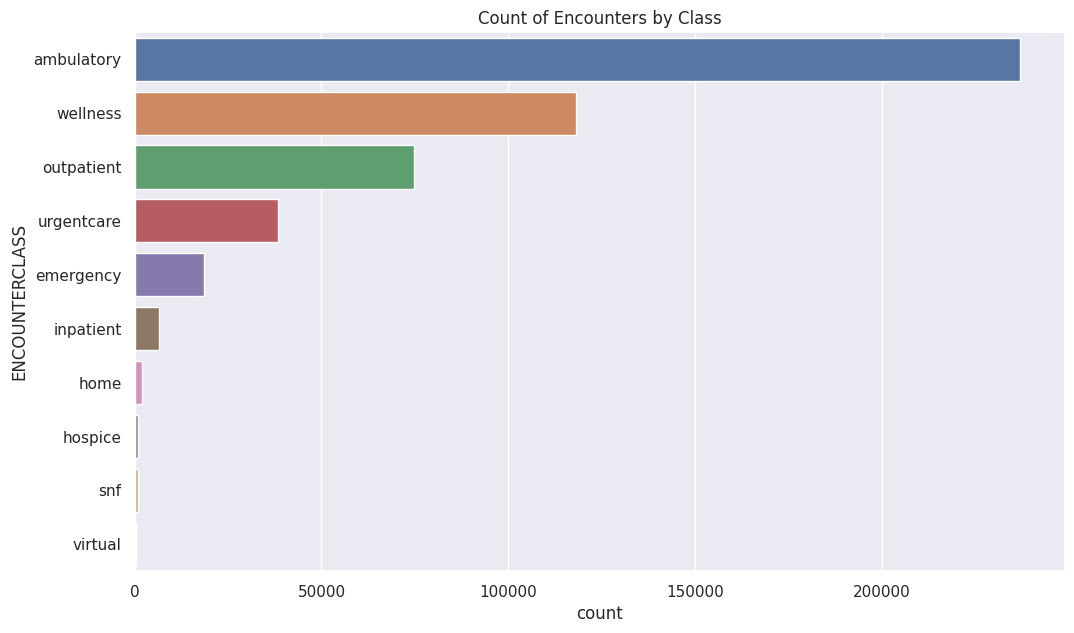

In [110]:
sns.countplot(data=encounters_df, 
              y='ENCOUNTERCLASS',
              order=encounters_df['ENCOUNTERCLASS'].value_counts().index)
plt.title('Count of Encounters by Class')
plt.show()

### Encounter Descriptions

In [ ]:
print('count of unique encounter descriptions:', encounters_df['DESCRIPTION'].nunique())

count of unique encounter descriptions: 68


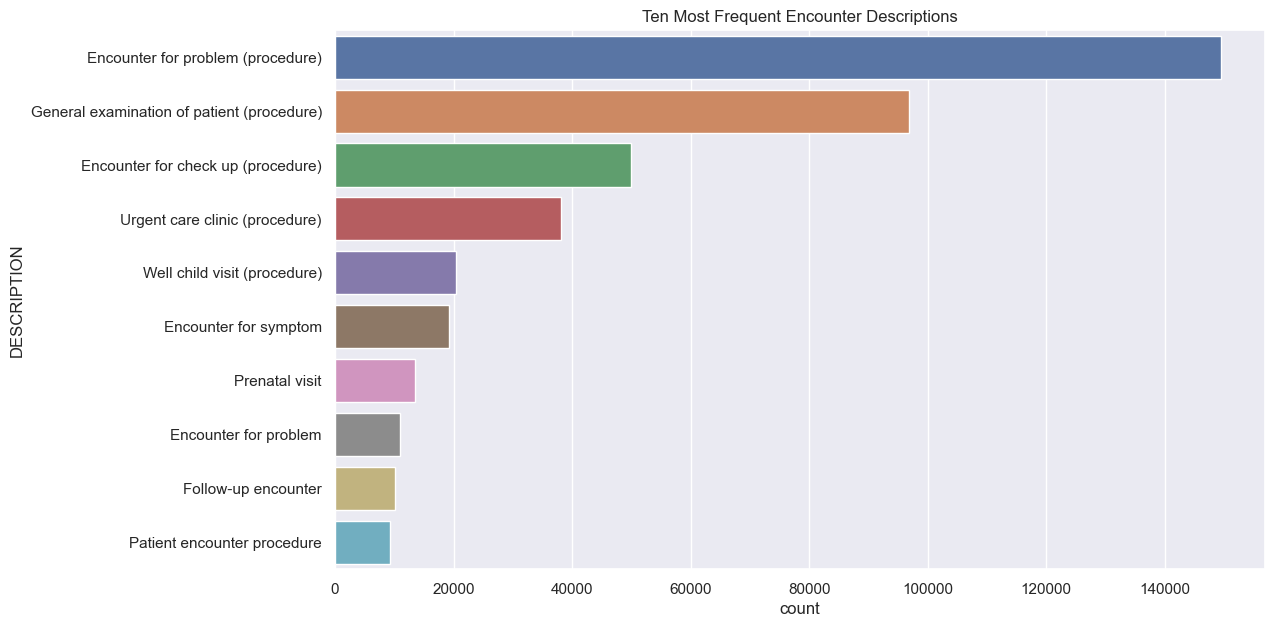

In [ ]:
# plot 10 most frequent encounter descriptions
sns.countplot(data=encounters_df,
                y='DESCRIPTION',
                order=encounters_df['DESCRIPTION'].value_counts().iloc[:10].index)
plt.title('Ten Most Frequent Encounter Descriptions')
plt.show()

## Encounter Code (SNOMED)

The encounter codes in our data are SNOMED codes, which are unique to the healthcare industry. FOr general clarification we will ask ChatGPT to help us better understand SNOMED codes. 

In [113]:
# count of unique SNOMED codes
print('Count of SNOMED Codes in the Encounters data:', encounters_df['CODE'].nunique())

Count of SNOMED Codes in the Encounters data: 56


In [112]:
prompt = f"""
I want you to act as a data scientist with experience in the healthcare domain and advise me about analyzing patient encounters.
My data contains {encounters_df['CODE'].nunique()} SNOMED codes. What are SNOMED codes, howe are they used in healthcare,
and why would they be relevant to my patient journey analysis?
How should I analyze them and use them in a Neo4j database?
"""

# create a new message history variable for this section
message_history = []

message_history, response_text = submit_query_and_append(prompt, message_history)
print(response_text)

As a language model AI, I don't have practical experience in the healthcare domain, but I can provide you with some general information about SNOMED codes and how they can be used in patient journey analysis.

SNOMED codes are a standardized system of medical terminology used to describe clinical concepts in healthcare. They are used to capture and communicate information about patient encounters, including diagnoses, symptoms, procedures, and medications. SNOMED codes are used by healthcare providers, researchers, and policymakers to improve patient care, track disease trends, and develop healthcare policies.

In patient journey analysis, SNOMED codes can be used to identify patterns and trends in patient encounters over time. By analyzing the frequency and sequence of SNOMED codes in patient records, healthcare providers can gain insights into the progression of diseases, the effectiveness of treatments, and the overall quality of care.

To use SNOMED codes in a Neo4j database, you c

In [122]:
prompt = f"""
I want you to act as an experienced data scientist and help me writecode to group two columns in a
pandas dataframe named encounters_df. I want count the most frequent combinations of features from the 
columns "DESCRIPTION" and "CODE" and then plot them in a horizontal bar chart, with the Y axis both 
DESCRIPTION AND CODE, and the  x-axis representing the count. 
"""

message_history, response_text = submit_query_and_append(prompt, message_history)
print(response_text)

Sure, here's some code that should do what you're asking for:

```python
import pandas as pd
import seaborn as sns

# Assuming you already have a pandas dataframe named encounters_df

# Group the dataframe by the two columns of interest and count the occurrences
grouped_df = encounters_df.groupby(['DESCRIPTION', 'CODE']).size().reset_index(name='count')

# Sort the dataframe by count in descending order
grouped_df = grouped_df.sort_values(by='count', ascending=False)

# Plot the horizontal bar chart using seaborn
sns.barplot(x='count', y=['DESCRIPTION', 'CODE'], data=grouped_df, orient='h')
```

This code should group the dataframe by the "DESCRIPTION" and "CODE" columns, count the occurrences of each combination, sort the results by count in descending order, and then plot the results in a horizontal bar chart using seaborn. The Y axis of the chart will show both "DESCRIPTION" and "CODE", and the X axis will show the count of each combination. Let me know if you have any questions or 

In [127]:
# Group the dataframe by the two columns of interest and count the occurrences
grouped_df = encounters_df.groupby(['DESCRIPTION', 'CODE']).size().reset_index(name='count')

# Sort the dataframe by count in descending order
grouped_df = grouped_df.sort_values(by='count', ascending=False)

# Plot the horizontal bar chart using seaborn
sns.barplot(x='count', y=['DESCRIPTION', 'CODE'], data=grouped_df, orient='h')

ValueError: ignored

In [134]:
prompt = f"""
Continuing the conversation, I ran the code you provided and received the following error:
'ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().'

Can you fix the code so that it runs and displays the plot properly? You don't need to use seaborn and can use pandas .plot() function.
I would like to keep the combination of DESCRIPTION and CODE on the y-axis.
"""

message_history, response_text = submit_query_and_append(prompt, message_history)
print(response_text)

Sure, here's an updated version of the code that should work using the pandas `.plot()` function:

```python
import pandas as pd

# Assuming you already have a pandas dataframe named encounters_df

# Group the dataframe by the two columns of interest and count the occurrences
grouped_df = encounters_df.groupby(['DESCRIPTION', 'CODE']).size().reset_index(name='count')

# Sort the dataframe by count in descending order
grouped_df = grouped_df.sort_values(by='count', ascending=False)

# Set the index of the dataframe to the combination of DESCRIPTION and CODE
grouped_df.set_index(['DESCRIPTION', 'CODE'], inplace=True)

# Plot the horizontal bar chart using pandas
grouped_df.plot(kind='barh', figsize=(10, 10))
```

In this updated code, we're using the pandas `.plot()` function to create a horizontal bar chart. We first group the dataframe by the `DESCRIPTION` and `CODE` columns and count the occurrences, then sort the results by count in descending order. We then set the index of the data

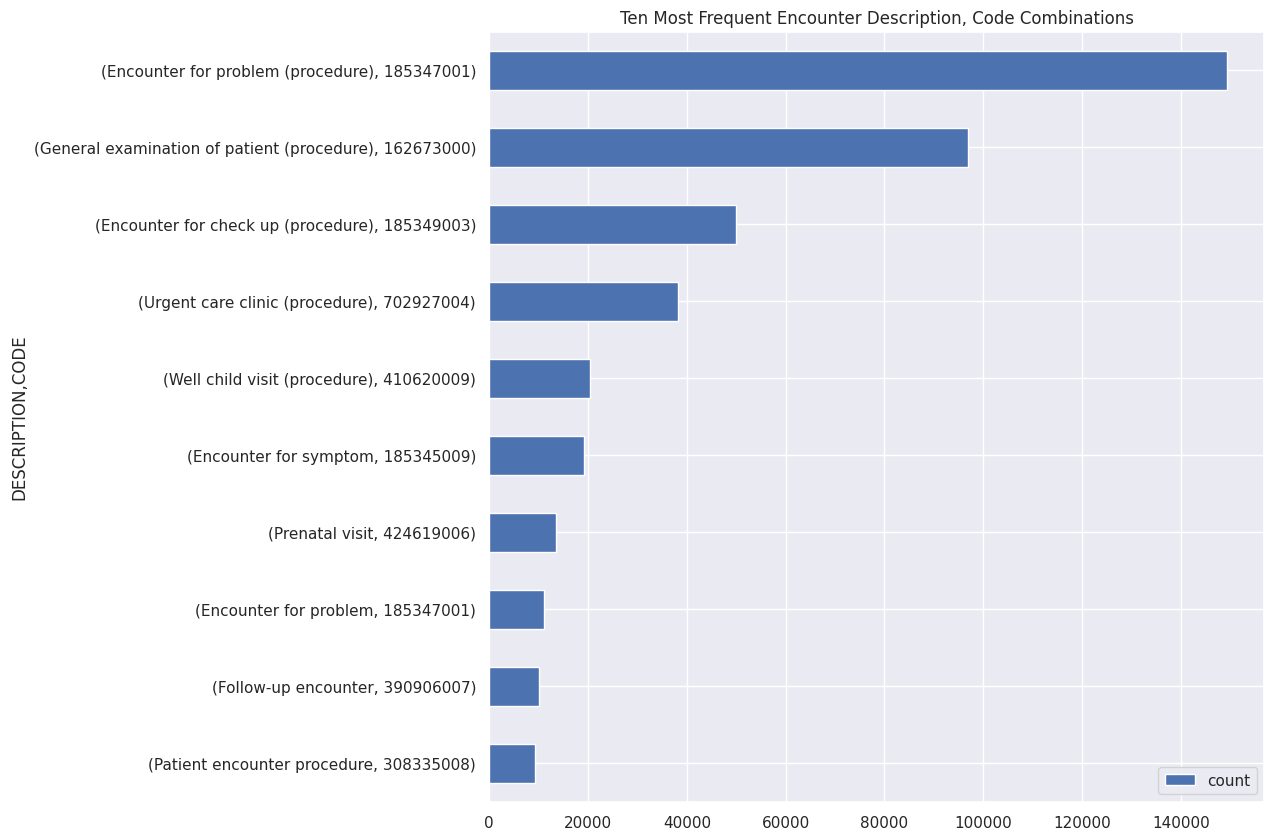

In [138]:
# Group the dataframe by the two columns of interest and count the occurrences
grouped_df = encounters_df.groupby(['DESCRIPTION', 'CODE']).size().reset_index(name='count')

# Sort the dataframe by count in descending order
grouped_df = grouped_df.sort_values(by='count', ascending=False)

# Set the index of the dataframe to the combination of DESCRIPTION and CODE
grouped_df.set_index(['DESCRIPTION', 'CODE'], inplace=True)

# Plot the horizontal bar chart using pandas
grouped_df[0:10].sort_values(by='count').plot(kind='barh', figsize=(10, 10))
plt.title('Ten Most Frequent Encounter Description, Code Combinations')
plt.show()

## Total Claim Costs

In [141]:
# statistical distribution
encounters_df['TOTAL_CLAIM_COST'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(0)

count     497415.0
mean        2584.0
std        10610.0
min            0.0
25%          621.0
50%          924.0
75%         1320.0
90%         3823.0
95%        11632.0
99%        35803.0
max      1229194.0
Name: TOTAL_CLAIM_COST, dtype: float64

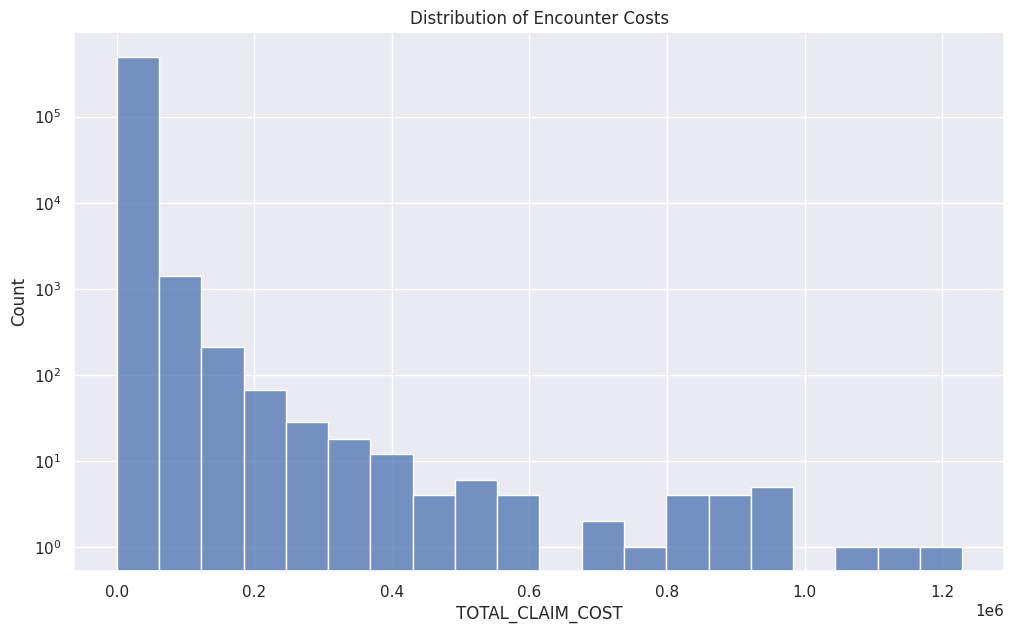

In [142]:
# plot encounter cost distribution  
sns.histplot(data=encounters_df, x='TOTAL_CLAIM_COST', bins=20, log=True)
plt.title('Distribution of Encounter Costs')
plt.show()

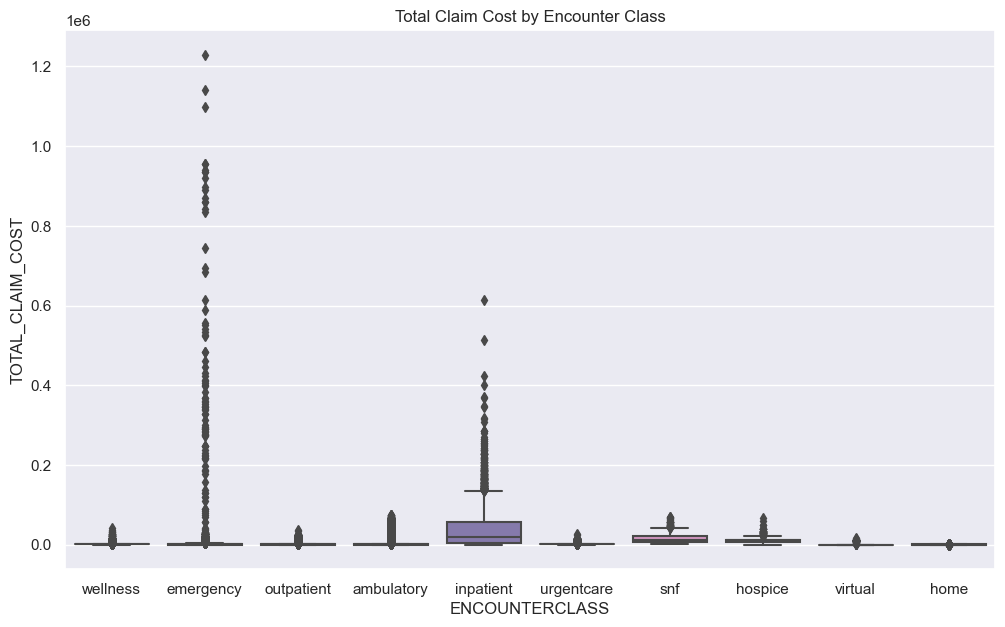

In [ ]:
sns.boxplot(data=encounters_df, x='ENCOUNTERCLASS', y='TOTAL_CLAIM_COST')
plt.title('Total Claim Cost by Encounter Class')
plt.show()

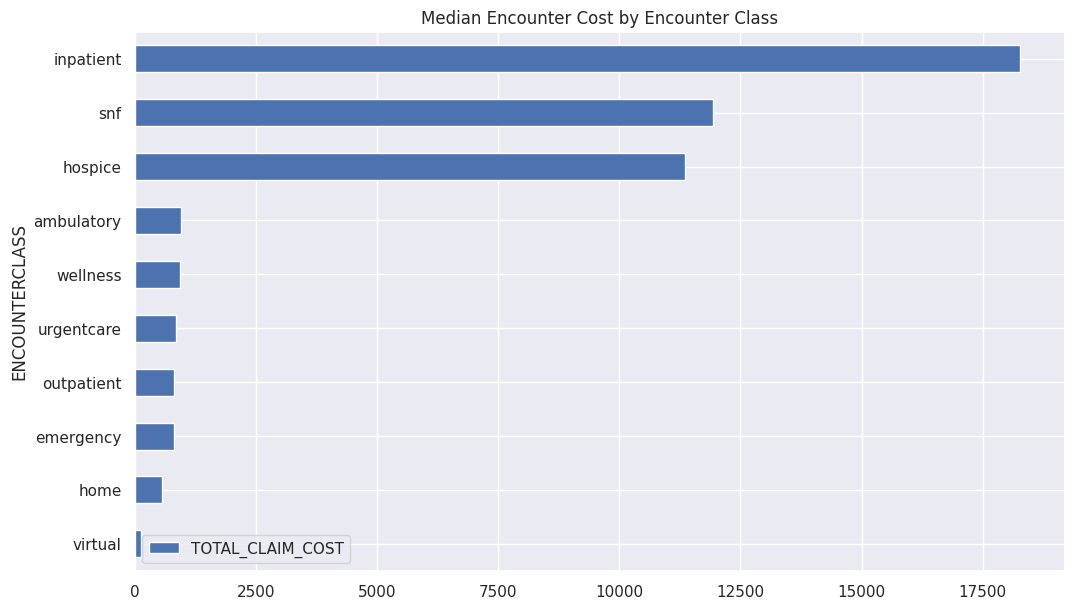

In [143]:
# median encounter cost by encounterclass 
(
    encounters_df[['ENCOUNTERCLASS', 'TOTAL_CLAIM_COST']]
    .groupby('ENCOUNTERCLASS')
    .median().round(2)
    .sort_values(by='TOTAL_CLAIM_COST')
    .plot(kind='barh')
)
plt.title('Median Encounter Cost by Encounter Class')
plt.show()

## Encounter Date Ranges

In [144]:
print('Earliest encounter start date:', encounters_df['START'].dt.date.min())
print('Most recent encounter start date:', encounters_df['START'].dt.date.max())

Earliest encounter start date: 1912-09-19
Most recent encounter start date: 2023-03-11


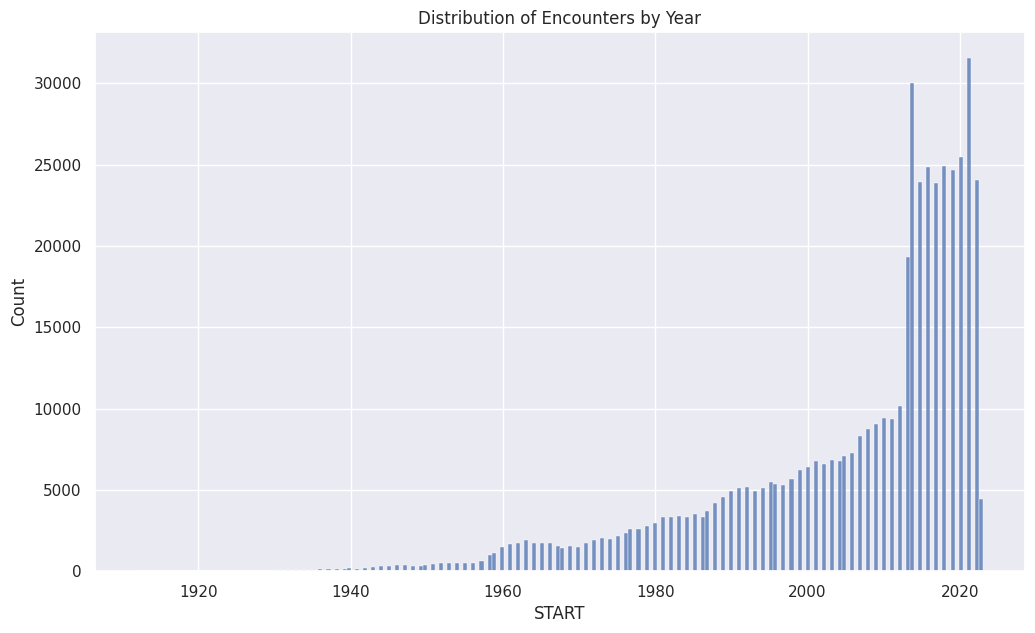

In [145]:
sns.histplot(encounters_df['START'].dt.year)
plt.title('Distribution of Encounters by Year')
plt.show()

## Ask ChatGPT for Encounter Data Model

In [148]:
prompt = f"""
I want you to act as an experienced graph data scientist who works at Neo4j.
I am interested in the following features, which have data types of: {encounters_df[['START', 'STOP', 'ENCOUNTERCLASS', 'DESCRIPTION', 'CODE', 'TOTAL_CLAIM_COST']].dtypes}.
I plan to ingest them into Neo4j for a patient journey analysis, along with other patient, procedure, and medications data. 
Patient nodes will connect to Encounter nodes via a [:HAS_ENCOUNTER] relationship. 
How should I model the encounter features listed above as nodes, relationships, and properties?
"""

message_history, response_text = submit_query_and_append(prompt, message_history)
print(response_text)

Great question! Here's one way you could model the encounter features as nodes, relationships, and properties in Neo4j:

1. Create a `Patient` node with properties for `PATIENT` and any other relevant patient information.

2. Create an `Encounter` node with properties for `START`, `STOP`, `ENCOUNTERCLASS`, `DESCRIPTION`, `CODE`, `TOTAL_CLAIM_COST`, and any other relevant encounter information.

3. Create relationships between the `Patient` node and each `Encounter` node using a `[:HAS_ENCOUNTER]` relationship.

4. Add any additional nodes and relationships as needed for other patient, procedure, and medication data.

Here's an example Cypher query that could be used to create the nodes and relationships:

```
// Create Patient node
CREATE (:Patient {PATIENT: 'patient_id', ...})

// Create Encounter node
CREATE (:Encounter {START: datetime('2022-01-01T00:00:00Z'), STOP: datetime('2022-01-02T00:00:00Z'), ENCOUNTERCLASS: 'class', DESCRIPTION: 'description', CODE: 'code', TOTAL_CLAIM_COST:

# Procedures Data

## Load and Pre-Process Data

In [12]:
procedures_df = pd.read_csv(DATA_DIRECTORY + 'procedures.csv')
procedures_df.shape

(785604, 9)

In [13]:
# convert start and stop to datetime objects
procedures_df['START'] = pd.to_datetime(procedures_df['START'])
procedures_df['STOP'] = pd.to_datetime(procedures_df['STOP'])

# convert code to an object
procedures_df['CODE'] = procedures_df['CODE'].astype('object')

In [14]:
procedures_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785604 entries, 0 to 785603
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   START              785604 non-null  datetime64[ns, UTC]
 1   STOP               785604 non-null  datetime64[ns, UTC]
 2   PATIENT            785604 non-null  object             
 3   ENCOUNTER          785604 non-null  object             
 4   CODE               785604 non-null  object             
 5   DESCRIPTION        785604 non-null  object             
 6   BASE_COST          785604 non-null  float64            
 7   REASONCODE         249782 non-null  float64            
 8   REASONDESCRIPTION  249782 non-null  object             
dtypes: datetime64[ns, UTC](2), float64(2), object(5)
memory usage: 53.9+ MB


In [15]:
procedures_df.head(2)

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,REASONCODE,REASONDESCRIPTION
0,2013-07-24 11:27:37+00:00,2013-07-24 11:57:37+00:00,faf277d8-c5c7-406c-f139-9143c35ff4e8,eebc17d4-d133-24f2-3502-a3640d3feaba,268425006,Pelvis X-ray,431.4,NaN,NaN
1,2013-07-24 11:27:37+00:00,2013-07-24 12:53:37+00:00,faf277d8-c5c7-406c-f139-9143c35ff4e8,eebc17d4-d133-24f2-3502-a3640d3feaba,305428000,Admission to orthopedic department,431.4,359817006.0,Closed fracture of hip


## Procedure Descriptions

In [17]:
# count of unique procedure descriptions
print('count of unique procedures:', procedures_df['DESCRIPTION'].nunique())

count of unique procedures: 339


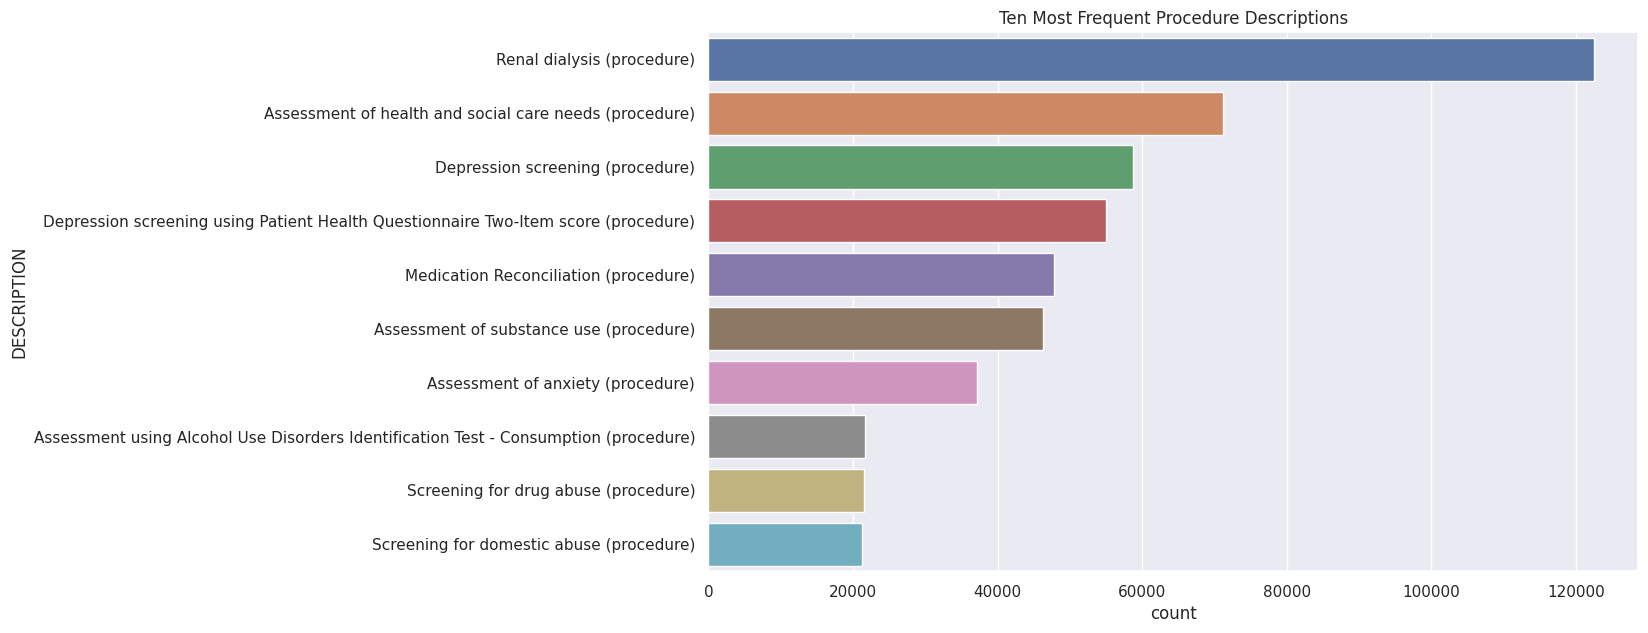

In [18]:
# plot 10 most frequent procedure descriptions
sns.countplot(data=procedures_df,
                y='DESCRIPTION',
                order=procedures_df['DESCRIPTION'].value_counts().iloc[:10].index)
plt.title('Ten Most Frequent Procedure Descriptions')
plt.show()

## Procedure Costs

In [19]:
# statistical distribution
procedures_df['BASE_COST'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(0)

count    785604.0
mean       1418.0
std        4209.0
min           0.0
25%         431.0
50%         431.0
75%         907.0
90%        2912.0
95%        7230.0
99%       14116.0
max      630389.0
Name: BASE_COST, dtype: float64

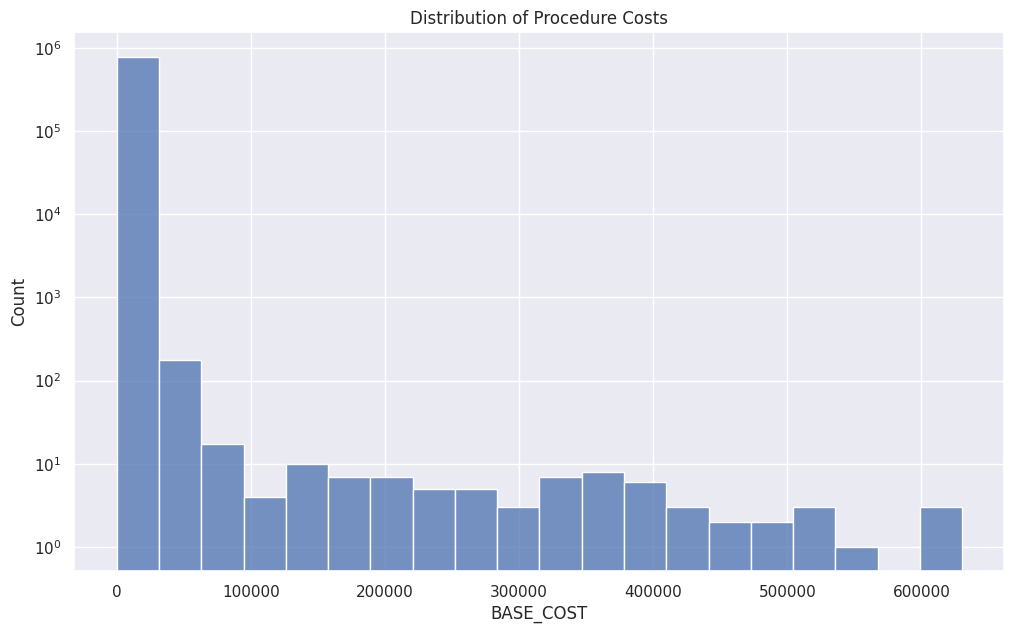

In [20]:
# plot encounter cost distribution  
sns.histplot(data=procedures_df, x='BASE_COST', bins=20, log=True)
plt.title('Distribution of Procedure Costs')
plt.show()

## Procedure Dates

In [22]:
print('Earliest procedure start date:', procedures_df['START'].dt.date.min())
print('Most recent procedure start date:', procedures_df['START'].dt.date.max())

Earliest procedure start date: 1924-01-26
Most recent procedure start date: 2023-03-11


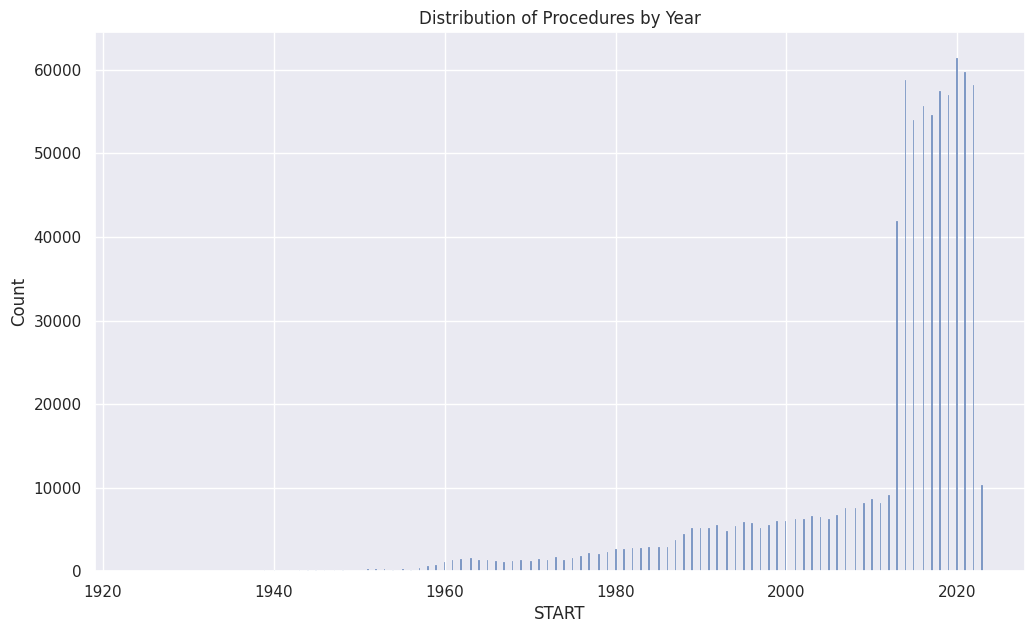

In [23]:
sns.histplot(procedures_df['START'].dt.year)
plt.title('Distribution of Procedures by Year')
plt.show()

## Ask ChatGPT for Procedures Graph Data Model

In [25]:
prompt = f"""
I want you to act as an experienced graph data scientist who works at Neo4j.
I am interested in the following features, which have data types of: {procedures_df[['START', 'DESCRIPTION', 'CODE', 'BASE_COST']].dtypes}.
I plan to ingest them into Neo4j for a patient journey analysis, along with other patient, procedure, and medications data. 
Patient nodes will connect to Encounter nodes via a [:HAS_ENCOUNTER] relationship.
Procedure nodes will connect to Encounter nodes via a [:HAS_PROCEDURE] relationship. 
How should I model the encounter features listed above as nodes, relationships, and properties?
"""

message_history, response_text = submit_query_and_append(prompt, message_history)
print(response_text)

To model the encounter features listed above as nodes, relationships, and properties in Neo4j, I would suggest the following approach:

1. Create a node label for Encounter: 

```
CREATE CONSTRAINT ON (e:Encounter) ASSERT e.id IS UNIQUE;
```

2. Create a node label for Procedure:

```
CREATE CONSTRAINT ON (p:Procedure) ASSERT p.id IS UNIQUE;
```

3. Create a relationship type for [:HAS_ENCOUNTER]:

```
CREATE TYPE HAS_ENCOUNTER;
```

4. Create a relationship type for [:HAS_PROCEDURE]:

```
CREATE TYPE HAS_PROCEDURE;
```

5. Create the Encounter nodes with the following properties:

```
CREATE (e:Encounter {id: <encounter_id>, start: <start_datetime>, description: <description>, code: <code>, base_cost: <base_cost>})
```

6. Create the Procedure nodes with the following properties:

```
CREATE (p:Procedure {id: <procedure_id>, description: <description>, code: <code>, base_cost: <base_cost>})
```

7. Connect the Patient nodes to Encounter nodes via the [:HAS_ENCOUNTER] relationship:

``

# Medications (Drugs) Data

## Load and Pre-Process Data

In [26]:
medications_df = pd.read_csv(DATA_DIRECTORY + 'medications.csv')
medications_df.shape

(604103, 13)

In [27]:
# convert start and stop to datetime objects
medications_df['START'] = pd.to_datetime(medications_df['START'])
medications_df['STOP'] = pd.to_datetime(medications_df['STOP'])

# convert code to an object
medications_df['CODE'] = medications_df['CODE'].astype('object')

## Ask ChatGPT for Medication EDA Guidance

In [28]:
prompt = f"""I have a dataframe of patient medications data that is already loaded into the pandas dataframe called medications_df. 
             The dataframe contains {medications_df.shape[0]} rows and the following features\n {medications_df.dtypes}\n 
             I plan to ingest this parts of this data into Neo4j and use it along with patient, encounter, and procedure data for a patient journey analysis. 
             I cannot use or analyze all of the encounter features, so which five to seven, excluding PATIENT, would likely most important 
             to include in my Neo4j graph data model as nodes, properties, or relationships?
             """

# create a new message history variable for this section
message_history = []

message_history, response_text = submit_query_and_append(prompt, message_history)
print(response_text)

Based on the information provided, the following five to seven encounter features would likely be the most important to include in the Neo4j graph data model:

1. START: This feature represents the start date and time of the medication, which is important for tracking the timing of the medication in relation to other events in the patient journey.

2. STOP: This feature represents the stop date and time of the medication, which is important for tracking the duration of the medication and any potential overlaps with other medications.

3. ENCOUNTER: This feature represents the encounter during which the medication was prescribed or administered, which is important for linking the medication to other relevant data points such as diagnoses, procedures, and providers.

4. CODE: This feature represents the code for the medication, which is important for identifying the specific medication and linking it to other relevant data points such as drug classes and indications.

5. DESCRIPTION: Thi

In [30]:
prompt = f"""I want you to act as an experienced data scientist and help me perform Exploratory Data Analysis on the patient medications data from before.
             What specific analysis should I perform on the following features: CODE, DESCRIPTION, BASE_COST, REASONDESCRIPTION
             Provide code examples in Python using pandas and seaborn. My data is already loaded into a pandas dataframe.
             """

message_history, response_text = submit_query_and_append(prompt, message_history)
print(response_text)

To perform exploratory data analysis on the patient medications data, we can start by analyzing the following features: CODE, DESCRIPTION, BASE_COST, and REASONDESCRIPTION. Here are some specific analysis that can be performed on these features:

1. CODE and DESCRIPTION:

We can start by analyzing the distribution of medication codes and descriptions in the dataset. This can be done using the following code:

```
import seaborn as sns

# Count the number of unique medication codes and descriptions
num_codes = len(medications_df['CODE'].unique())
num_desc = len(medications_df['DESCRIPTION'].unique())

print("Number of unique medication codes: ", num_codes)
print("Number of unique medication descriptions: ", num_desc)

# Plot the top 10 most common medication codes
top_codes = medications_df['CODE'].value_counts().head(10)
sns.barplot(x=top_codes.index, y=top_codes.values)
plt.title('Top 10 most common medication codes')
plt.xlabel('Medication code')
plt.ylabel('Count')
plt.show()

# Plo

## General Medications Data EDA

In [31]:
medications_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604103 entries, 0 to 604102
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   START              604103 non-null  datetime64[ns, UTC]
 1   STOP               586915 non-null  datetime64[ns, UTC]
 2   PATIENT            604103 non-null  object             
 3   PAYER              604103 non-null  object             
 4   ENCOUNTER          604103 non-null  object             
 5   CODE               604103 non-null  object             
 6   DESCRIPTION        604103 non-null  object             
 7   BASE_COST          604103 non-null  float64            
 8   PAYER_COVERAGE     604103 non-null  float64            
 9   DISPENSES          604103 non-null  int64              
 10  TOTALCOST          604103 non-null  float64            
 11  REASONCODE         550098 non-null  float64            
 12  REASONDESCRIPTION  550098 non-

In [32]:
medications_df.isna().sum()

START                    0
STOP                 17188
PATIENT                  0
PAYER                    0
ENCOUNTER                0
CODE                     0
DESCRIPTION              0
BASE_COST                0
PAYER_COVERAGE           0
DISPENSES                0
TOTALCOST                0
REASONCODE           54005
REASONDESCRIPTION    54005
dtype: int64

In [33]:
medications_df.head(2)

,START,STOP,PATIENT,PAYER,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,REASONDESCRIPTION
0,2013-07-24 12:53:37+00:00,2013-08-20 11:16:28+00:00,faf277d8-c5c7-406c-f139-9143c35ff4e8,df166300-5a78-3502-a46a-832842197811,eebc17d4-d133-24f2-3502-a3640d3feaba,861467,Meperidine Hydrochloride 50 MG Oral Tablet,53.88,0.0,1,53.88,NaN,NaN
1,2013-07-24 12:53:37+00:00,2013-10-01 12:53:37+00:00,faf277d8-c5c7-406c-f139-9143c35ff4e8,df166300-5a78-3502-a46a-832842197811,eebc17d4-d133-24f2-3502-a3640d3feaba,313782,Acetaminophen 325 MG Oral Tablet,124.87,0.0,2,249.74,NaN,NaN


## Medication Codes and Descriptions

In [34]:
# Count the number of unique medication codes and descriptions

print("Number of unique medication codes: ", medications_df['CODE'].nunique())
print("Number of unique medication descriptions: ", medications_df['DESCRIPTION'].nunique())

Number of unique medication codes:  326
Number of unique medication descriptions:  340


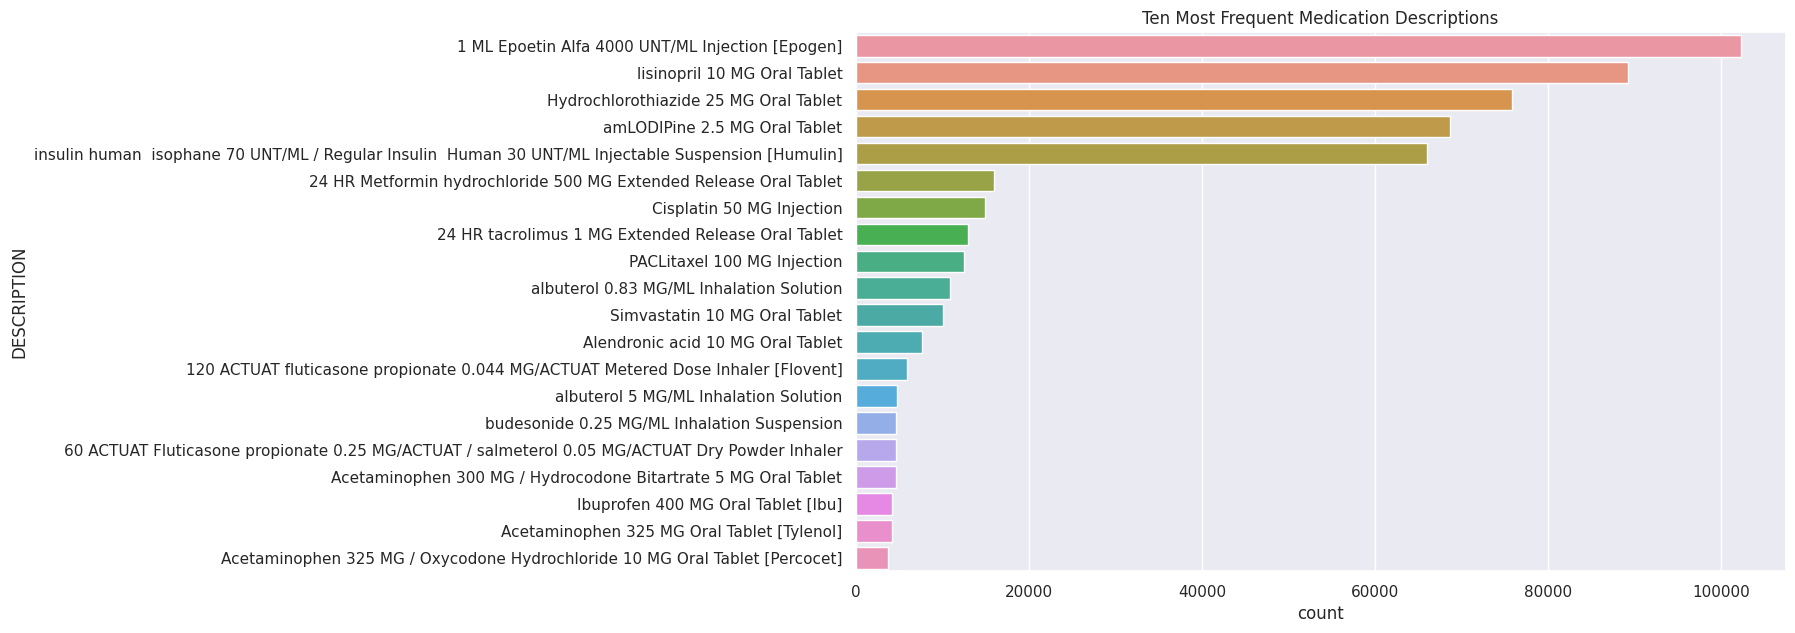

In [35]:
# plot 20 most frequent medication descriptions
sns.countplot(data=medications_df,
                y='DESCRIPTION',
                order=medications_df['DESCRIPTION'].value_counts().iloc[:20].index)
plt.title('Ten Most Frequent Medication Descriptions')
plt.show()

## Medication Base Cost

In [ ]:
medications_df['BASE_COST'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(0)

count    604103.0
mean         99.0
std        1015.0
min           0.0
25%           1.0
50%          30.0
75%         130.0
90%         256.0
95%         355.0
99%         618.0
max      102723.0
Name: BASE_COST, dtype: float64

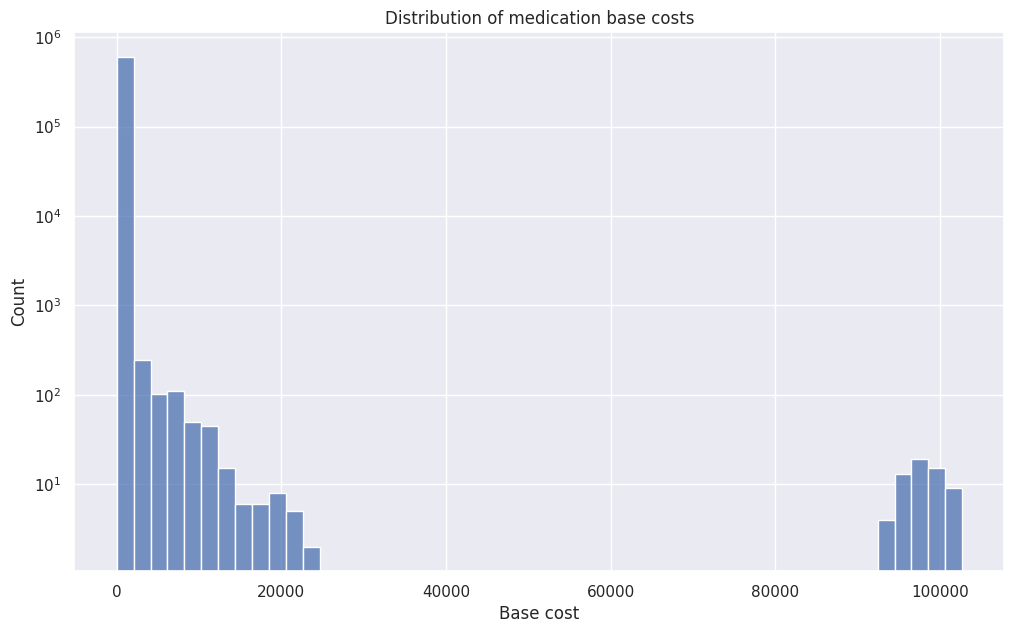

In [37]:
sns.histplot(data=medications_df, x='BASE_COST', bins=50, log=True)
plt.title('Distribution of medication base costs')
plt.xlabel('Base cost')
plt.ylabel('Count')
plt.show()

## Reason Description

In [38]:
print('count of reason descriptions:', medications_df['REASONDESCRIPTION'].nunique())

count of reason descriptions: 59


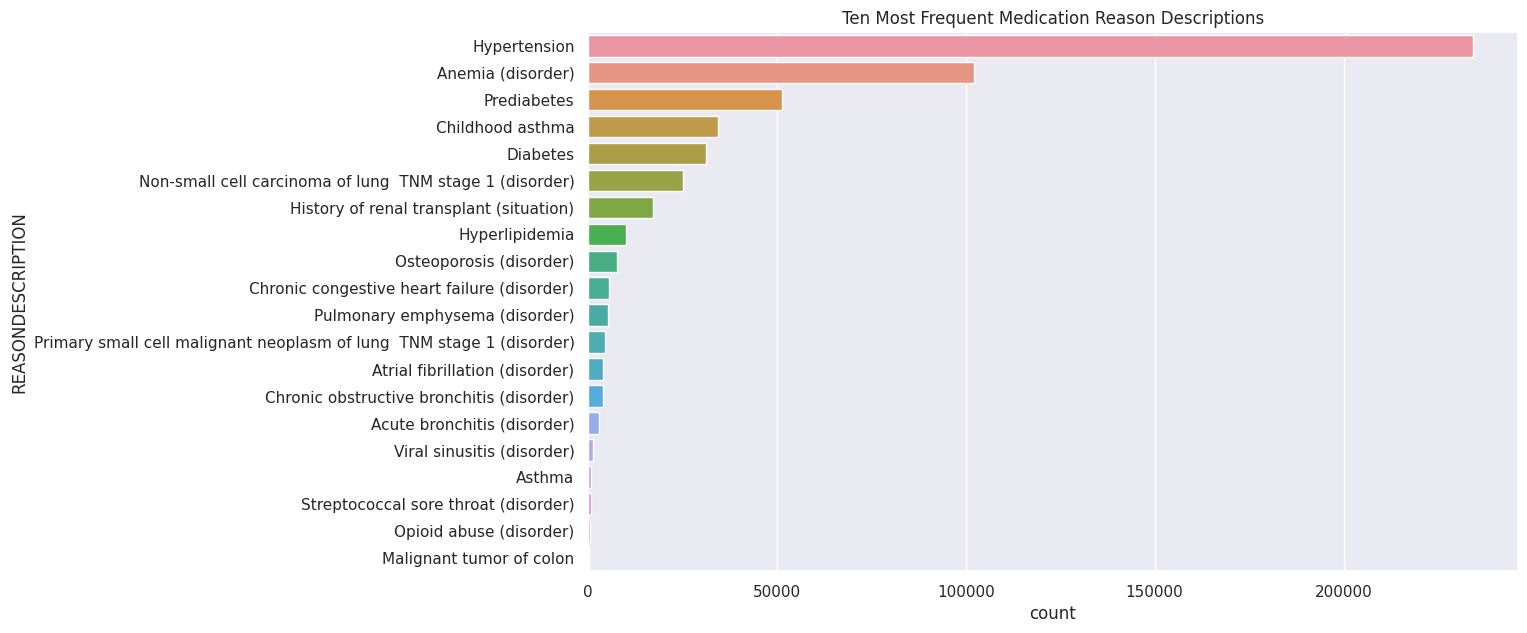

In [39]:
# plot 20 most frequent medication reason descriptions
sns.countplot(data=medications_df,
                y='REASONDESCRIPTION',
                order=medications_df['REASONDESCRIPTION'].value_counts().iloc[:20].index)
plt.title('Ten Most Frequent Medication Reason Descriptions')
plt.show()

## Ask ChatGPT for Medications (Drugs) Graph Data Model

In [40]:
prompt = f"""
I want you to act as an experienced graph data scientist who works at Neo4j.
I am interested in the following medication data features, which have data types of: {medications_df[['CODE', 'DESCRIPTION', 'BASE_COST', 'REASONDESCRIPTION']].dtypes}.
I plan to ingest them into Neo4j for a patient journey analysis, along with other patient, procedure, and encounter data. 
Patient nodes will connect to Encounter nodes via a [:HAS_ENCOUNTER] relationship.
Procedure nodes will connect to Encounter nodes via a [:HAS_PROCEDURE] relationship. 
Medications will be connected to Encounter nodes via a [:HAS_ENCOUNTER] relationship.
How should I model the encounter features listed above as nodes, relationships, and properties?
"""

message_history, response_text = submit_query_and_append(prompt, message_history)
print(response_text)

Based on the information provided, here is a possible way to model the encounter features as nodes, relationships, and properties in Neo4j:

1. Encounter nodes: Each encounter in the dataset can be modeled as a node in Neo4j with the following properties:

- ID: A unique identifier for the encounter
- START: The start date and time of the encounter
- STOP: The stop date and time of the encounter
- PATIENT_ID: The ID of the patient associated with the encounter

2. Medication nodes: Each medication in the dataset can be modeled as a node in Neo4j with the following properties:

- ID: A unique identifier for the medication
- CODE: The code for the medication
- DESCRIPTION: The description of the medication
- BASE_COST: The base cost of the medication
- REASONDESCRIPTION: The reason for the medication prescription or administration

3. Relationships:

- [:HAS_ENCOUNTER]: This relationship connects a patient node to an encounter node and a medication node to an encounter node. It represent